In [759]:
# !pip install openmeteo-requests
# !pip install requests-cache retry-requests numpy pandas

In [ ]:
# plan 
# wstawic wukresy do presentacji, napisac wyniki (dla grup temperatura/percipitation/humidity tez) n grams, popularne slowa, lokacje, wyrazy z pogoda
# 1 pytanie ? czy wstawic do prezentsacji metody, jakimi polaczylem dane, ze robilem to recznie, potem jak oczyscilem tekst (stopwrods, lemmatisation)
# jak tak to raczej takimi obrazkami (bez kodu)
# 2 jak wycignalem wyrazy z wpisow zwiazane z lokacja, pogoda i td..., jak robilem n grams, czy tylko wykresy i ich analiza)
# 3 co moze byc zle, ze nie odkrywam roznicy wpisow dla roznej pogody? posty jakby wsztstkie o tym samym caly czas (niezaleznie od pogody)
# jak mozna opisac to, ze
# 4 czy pokazywac wszystkie wykresy z popularnymi slowami/ngrams bo jest duzo tych samych
#  5 czy moze byc kod w prezentacji?
# 6 czy struktura prezentacji okej?
# 7 czy pokazac kawalek z clustering (nieudana niedokonczona proba)
# 

# ... 

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import openmeteo_requests

import requests_cache
from retry_requests import retry

In [5]:
users = pd.read_csv("/Users/admin/Downloads/Users.csv")
posts = pd.read_csv("/Users/admin/Downloads/Posts.csv")

In [451]:
users.shape

(89120, 12)

In [463]:
df_test = users[["Id", "CreationDate", "DisplayName", "Location", "AboutMe"]]
df_test[(df_test["Id"] == 9)]

,Id,CreationDate,DisplayName,Location,AboutMe
7,9,2011-06-21T20:18:16.290,silent1mezzo,"Toronto, Canada",<p>I'm a django developer for a Travel company...


In [7]:
users.head()

,Id,Reputation,CreationDate,DisplayName,LastAccessDate,WebsiteUrl,Location,AboutMe,Views,UpVotes,DownVotes,AccountId
0,-1,1,2011-06-21T15:16:44.253,Community,2011-06-21T15:16:44.253,http://meta.stackexchange.com/,on the server farm,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",301,6309,24166,-1.0
1,2,101,2011-06-21T20:10:03.720,Geoff Dalgas,2017-10-09T14:25:03.613,http://stackoverflow.com,"Corvallis, OR",<p>Dev #2 who helped create Stack Overflow cur...,41,1,0,2.0
2,3,101,2011-06-21T20:11:02.490,Nick Craver,2019-11-13T23:54:04.630,https://nickcraver.com/blog/,"Winston-Salem, NC",<p>I am the Architecture Lead for Stack Overfl...,22,1,0,7598.0
3,4,101,2011-06-21T20:12:21.223,Emmett,2019-09-05T02:57:12.997,http://minesweeperonline.com,"San Francisco, CA","<p>co-founder of <a href=""https://airtable.com...",15,1,0,1998.0
4,5,101,2011-06-21T20:15:31.410,Kevin Montrose,2019-05-21T18:43:29.443,https://kevinmontrose.com,"New York, NY, United States","<p><a href=""http://blog.stackoverflow.com/2010...",14,3,0,29738.0


In [8]:
posts.shape

(116146, 22)

In [649]:
posts[["Id", "PostTypeId", "CreationDate", "Score", "Body", "OwnerUserId"]]
example_for_presentation = posts[["Id", "PostTypeId", "CreationDate", "Score", "Body", "OwnerUserId"]].copy()
example_for_presentation.rename(columns={"OwnerUserId":"Użytkownik", \
                                         "Body":"Tekst"})

,Id,PostTypeId,CreationDate,Score,Tekst,Użytkownik
0,1,1,2011-06-21T20:19:34.730,8,<p>My fiancée and I are looking for a good Car...,9.0
1,2,1,2011-06-21T20:22:33.760,43,"<p>This was one of our definition questions, b...",13.0
2,3,2,2011-06-21T20:24:28.080,15,<p>One way would be to go through an Adventure...,9.0
3,4,1,2011-06-21T20:24:57.160,8,<p>Singapore Airlines has an all-business clas...,24.0
4,5,1,2011-06-21T20:25:56.787,14,<p>Another definition question that interested...,13.0
...,...,...,...,...,...,...
116141,168549,1,2021-09-04T23:30:40.353,0,<p>I am a dual citizen of USA and Pakistan.</p...,122819.0
116142,168550,1,2021-09-04T23:48:01.310,-1,<p>Assume that:</p>\n<ol>\n<li>I have a valid ...,1810.0
116143,168551,2,2021-09-05T01:44:19.417,0,"<p>In 2015, I found an even older CHF 50 bankn...",75.0
116144,168552,1,2021-09-05T02:18:05.140,-2,"<p>After those challenging years, cruise lines...",75.0


In [9]:
posts.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,Tags,AnswerCount,CommentCount,ClosedDate,ContentLicense,FavoriteCount,ParentId,LastEditorDisplayName,CommunityOwnedDate,OwnerDisplayName
0,1,1,393.0,2011-06-21T20:19:34.730,8,578.0,<p>My fiancée and I are looking for a good Car...,9.0,101.0,2011-12-28T21:36:43.910,...,<caribbean><cruising><vacations>,4.0,4,2013-02-25T23:52:47.953,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,2011-06-21T20:22:33.760,43,3255.0,"<p>This was one of our definition questions, b...",13.0,19400.0,2021-04-27T00:47:20.470,...,<guides><extreme-tourism><amazon-river><amazon...,8.0,4,NaN,CC BY-SA 4.0,5.0,NaN,NaN,NaN,NaN
2,3,2,NaN,2011-06-21T20:24:28.080,15,NaN,<p>One way would be to go through an Adventure...,9.0,NaN,NaN,...,NaN,NaN,2,NaN,CC BY-SA 3.0,NaN,2.0,NaN,NaN,NaN
3,4,1,NaN,2011-06-21T20:24:57.160,8,291.0,<p>Singapore Airlines has an all-business clas...,24.0,693.0,2013-01-09T09:55:22.743,...,<loyalty-programs><routes><ewr><singapore-airl...,1.0,1,NaN,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN
4,5,1,770.0,2011-06-21T20:25:56.787,14,476.0,<p>Another definition question that interested...,13.0,101.0,2011-12-28T21:36:18.230,...,<romania><transportation>,5.0,0,NaN,CC BY-SA 3.0,2.0,NaN,NaN,NaN,NaN


In [10]:
posts_users = posts.merge(users, how = "inner", left_on = "OwnerUserId", right_on = "Id", suffixes = ["_posts", "_users"])
posts_users.shape, posts_users.columns

((112919, 34),
 Index(['Id_posts', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate_posts',
        'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId',
        'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
        'CommentCount', 'ClosedDate', 'ContentLicense', 'FavoriteCount',
        'ParentId', 'LastEditorDisplayName', 'CommunityOwnedDate',
        'OwnerDisplayName', 'Id_users', 'Reputation', 'CreationDate_users',
        'DisplayName', 'LastAccessDate', 'WebsiteUrl', 'Location', 'AboutMe',
        'Views', 'UpVotes', 'DownVotes', 'AccountId'],
       dtype='object'))

In [465]:
posts_users_TEXT = posts_users[["CreationDate_posts", "Body", "Title", "Tags", "Location"]]
posts_users_TEXT.head()

,CreationDate_posts,Body,Title,Tags,Location
0,2011-06-21T20:19:34.730,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,<caribbean><cruising><vacations>,"Toronto, Canada"
1,2011-06-21T20:24:28.080,<p>One way would be to go through an Adventure...,NaN,NaN,"Toronto, Canada"
2,2011-06-21T20:32:35.530,<p>There are a few ways to visit Antarctica. R...,NaN,NaN,"Toronto, Canada"
3,2011-06-21T20:58:13.947,<p>Google's your friend. I would definitely se...,NaN,NaN,"Toronto, Canada"
4,2011-06-21T21:01:11.480,<p>Here are two great communities for discussi...,NaN,NaN,"Toronto, Canada"


In [466]:
posts_users_TEXT.shape

(112919, 5)

In [467]:
# pewne przyklady postow z posts_users_TEXT

In [469]:
def show_me_Text_col(data_frame, col, i=0, n=10):
    body = data_frame[col].reset_index().drop(columns = "index")
    for j in range(n):
        print("Comment " + str(j), end='\n\n')
        print(body.loc[i+j, col])
show_me_Text_col(posts_users_TEXT, col="Body")

Comment 0

<p>My fiancée and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?</p>

<p>It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.</p>

<p><strong>EDIT</strong> We'll be travelling in 2012.</p>

Comment 1

<p>One way would be to go through an Adventure travel company that offers trips in the region. They'll have their own trained guides that have extensive knowledge of the area and will generally have lots of reviews so you can get an idea of whether or not the trip is good.</p>

<p><strong>Examples</strong></p>

<p><a href="http://www.gapadventures.com/">http://www.gapadventures.com/</a> - Great trips through the <a href="http://www.gapadventures.com/trips/?q=Amazon&amp;ref=finder">amazon</a></p>

<p><a href="http://contiki.com">http://contiki.com</a></p>

<p><a href="http://www.adventure-life.com/">http://www.adventure-life.c

In [15]:
# pomysl? zobaczyc do jakich krajow podrozuja mieszkancy posczegolnych krajow (czy jest zaleznosc od temperatury?)
# Czy posty odzwierciedlaja pogode ? takie wyrazy jak hot/cold/freezing/raining etc z polaczeniem z pogoda (po przejrzeniu postow, tresc
# ich glownie nie o pogodzie... a techniczne pytania, takie jak otrzymanie wizy, miejsca d zwiedzania,)
# chociaz czy sie uda wycignac takie wyrazy?
# i zobaczyc 

In [16]:
# Jak pogoda wplywa na wpisy na travel Exchange
# 1)jak użytkownicy reagują na różne warunki pogodowe w kontekście podróży (negatywnie, pozytywnie, neutralnie)
# jaki jest nastroj postow?
# 2) zaleznosc temat wpisu od warunkow pogody
# 3) chmura slow / mapa ciepla jako zaleznosc najczesciej uzywanych slow od pogody
# 4) preferowane destynacje? w zaleznosci od warunkow pogodowych (czyli czy jezdza ludzie do krajow chlodniejszych z cieplych
# i czy na odwrot?)
# 5) zwiazek warunki pogodowe a ilosc postow? w skali miesiaca?
# 6) outliers/anomalies?
# 7) Use techniques like classification or clustering to group travel posts based on similar weather conditions.
# 2. pytanie... zobaczyc jakie posty/tematy charakteryzuja poszczegolne warunki pogodowe 
# jakie warunki pogodowe maja najwieszy wplyw na tresc postow?

In [17]:
# co zrobic, zeby odpowiedziec na postawione pytania?
# 1) trzeba wyroznic posty na tematy (ewentualnie na pozytywne/negatywne)
# 2) znalezc najczesciej uzywane slowa (zobaczyc dla postow w zaleznosci od pogody), czyli dla dni z pogoda ciepla/zimna/wilgotna
# 3) znalezc dla krajow z pogoda ciepla/zimna/wilgotna destynacje i td...

In [18]:
# Najistotniejsze, sprobowac pogrupowac posty wedlug podobnych warunkow pogody!!!
# Mamy komentzrzy do postow (usery moga byc z roznych krajow), posty jako pytania, odpowiedzi (tez z roznych)
# zrobic merge wszystkiego i patrzec po lokalizacji uzytkownikow bedzie okej
# mozna wziac miejscowosc oraz dla niej wybrac dni cieple/zimne/wilgotne albo miesiace?
# pasuja wszystkie miejscowosci, z ktorych sa usery
# !!! Bardziej elegancko zrobic merge wszystkich wpisow, wedlug lokalizacji oraz daty (czyli zobaczyc pogode w konkretnym miejscu w tym czasie)
# oraz zklasteryzowac wpisy wedlug podobnej pogody potem zrobic analize tych grup (slowa, nastroj, tematy) i td...

In [19]:
# PLAN 
# 1) miec dataframe'y comments, posts polaczone z userami (czyli z kolumnami CreationDate oraz Lokalizacja)
# 2) zobaczyc co mamy
# 3) napisac skrypt do wycigniecia pogody dla posczegolnych miast
# 4) zmergowac pogode w te godzine w tym miescie z wpisami (comments, posts)
# 5) podzielic na grupy wpisy wedlug podobnej pogody
# 6) zrobic analize wpisow w kazdej grupie (...) 

In [20]:
# mam watpliwosci do danych, z ktorych korzystam posty wygladaja jako komentarze a nie jako pytania, bo faktycznie sa zarowno pytania
# jak i odpowiedzi na nie

In [21]:
# posts[posts.Id == 130325] # cztli faktycznie sa takie wiersze i td...

In [22]:
comments = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2011_2015.csv')
comments.shape
comments.head()

,Id,PostId,Score,Text,CreationDate,UserDisplayName,UserId,ContentLicense
0,180783,10862,0,Tipping for me depends on the level of service...,2014-06-09 19:34:39,NaN,15237.0,CC BY-SA 3.0
1,1,1,0,To help with the cruise line question: Where a...,2011-06-21 20:25:14,NaN,12.0,CC BY-SA 3.0
2,2,1,0,"Toronto, Ontario. We can fly out of anywhere t...",2011-06-21 20:27:35,NaN,9.0,CC BY-SA 3.0
3,3,1,3,"""Best"" for what? Please read [this page](http...",2011-06-21 20:32:23,NaN,20.0,CC BY-SA 3.0
4,9,25,0,"Are you in the UK? If so, would be helpful to ...",2011-06-21 20:42:08,NaN,30.0,CC BY-SA 3.0


In [470]:
show_me_Text_col(comments, "Text")

Comment 0

Tipping for me depends on the level of service. I have had experienced good, bad, and worse services and I did 15%, 10%, and 5% respectively.
Comment 1

To help with the cruise line question: Where are you located? My wife and I live in New Orleans, so we sail out of the port here. It limits us mainly to Carnival (though we are getting some more cruise lines in here), but saves us money on travel expenses getting *to* the port. If you're closer to a specific port, and like the cruises offered out of it, then it would make more sense to choose a cruise line from there.
Comment 2

Toronto, Ontario. We can fly out of anywhere though.
Comment 3

"Best" for what?  Please read [this page](http://travel.stackexchange.com/questions/how-to-ask-beta) and particularly the blog posts linked on the right.
Comment 4

Are you in the UK? If so, would be helpful to edit your post to reflect that.
Comment 5

Where are you starting from, and what sort of places were you hoping to visit?
Commen

In [24]:
# ciekawostka, komentarze bardziej sie nadaja do analizy sentymentalnej, bo sa w mniej technicznym stylu, wyrazajace emocje
# czy tym sie zajac ? jako pomysl...

In [25]:
# mam zainstolowane komentarzy

In [26]:
# robie comments dataframe

In [27]:
comments_11_15 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2011_2015.csv')
comments_15_16 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2015_2016.csv')
comments_16_17 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2016_2017.csv')
comments_17_18 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2017_2018.csv')
comments_18_19 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2018_2019.csv')
comments_19_20 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2019_2020.csv')
comments_20_21 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2020_2021.csv')
comments_21_22 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2021_2022.csv')
comments_22_23 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2022_2023.csv')
comments_23_24 = pd.read_csv('/Users/admin/Downloads/rafalkoj-lab10_promy_gr1-14b830a2d9fb/comments_2023_now.csv')

In [28]:
comments = pd.concat([comments_11_15, comments_15_16, comments_16_17, comments_16_17,
                     comments_17_18, comments_18_19, comments_19_20, comments_20_21,
                     comments_21_22, comments_22_23, comments_23_24],
                     ignore_index=True)
comments.shape, users.shape

((352776, 8), (89120, 12))

In [29]:
comments.head()

,Id,PostId,Score,Text,CreationDate,UserDisplayName,UserId,ContentLicense
0,180783,10862,0,Tipping for me depends on the level of service...,2014-06-09 19:34:39,NaN,15237.0,CC BY-SA 3.0
1,1,1,0,To help with the cruise line question: Where a...,2011-06-21 20:25:14,NaN,12.0,CC BY-SA 3.0
2,2,1,0,"Toronto, Ontario. We can fly out of anywhere t...",2011-06-21 20:27:35,NaN,9.0,CC BY-SA 3.0
3,3,1,3,"""Best"" for what? Please read [this page](http...",2011-06-21 20:32:23,NaN,20.0,CC BY-SA 3.0
4,9,25,0,"Are you in the UK? If so, would be helpful to ...",2011-06-21 20:42:08,NaN,30.0,CC BY-SA 3.0


In [30]:
# laczenie komentarzy z userami

In [31]:
comments_users = comments.merge(users, how = "inner", left_on = "UserId", right_on = "Id", suffixes = ["_posts", "_users"])

In [32]:
comments_users.shape

(333930, 20)

In [33]:
comments_users.head(1)

,Id_posts,PostId,Score,Text,CreationDate_posts,UserDisplayName,UserId,ContentLicense,Id_users,Reputation,CreationDate_users,DisplayName,LastAccessDate,WebsiteUrl,Location,AboutMe,Views,UpVotes,DownVotes,AccountId
0,180783,10862,0,Tipping for me depends on the level of service...,2014-06-09 19:34:39,NaN,15237.0,CC BY-SA 3.0,15237,108,2014-06-04T16:22:38.887,Sagar Rao,2015-02-27T09:19:07.000,https://code.sagar.buzz,"Austin, TX, USA","<p>I help in AI/MLOps, Cloud, Xtreme Programmi...",36,5,0,1119603.0


In [34]:
# modyfukijemy date
comments_users.CreationDate_posts = pd.to_datetime(comments_users.CreationDate_posts).dt.round('H')

In [35]:
comments_users.columns

Index(['Id_posts', 'PostId', 'Score', 'Text', 'CreationDate_posts',
       'UserDisplayName', 'UserId', 'ContentLicense', 'Id_users', 'Reputation',
       'CreationDate_users', 'DisplayName', 'LastAccessDate', 'WebsiteUrl',
       'Location', 'AboutMe', 'Views', 'UpVotes', 'DownVotes', 'AccountId'],
      dtype='object')

In [36]:
comments_users_TEXT = comments_users[["CreationDate_posts", "Text", "Location"]]
comments_users_TEXT.head(1)

,CreationDate_posts,Text,Location
0,2014-06-09 20:00:00,Tipping for me depends on the level of service...,"Austin, TX, USA"


In [37]:
from collections import Counter

locations = Counter(comments_users.Location)

locations = pd.DataFrame.from_dict(locations, orient='index', columns=['Count']).reset_index()

locations = locations.rename(columns={'index': 'locations'})

locations_sorted = locations.sort_values(by = "Count", ascending = False).reset_index(drop=True)

In [38]:
# najwiecej postow z tych miast... w komentarzy

In [39]:
locations_sorted

,locations,Count
0,NaN,125127
1,"New York, NY",15891
2,UK,14126
3,"London, United Kingdom",8044
4,Netherlands,7028
...,...,...
2443,"Ambalangoda, Sri Lanka",1
2444,"Puerto Maldonado, Peru",1
2445,"Ft Lauderdale, FL, United States",1
2446,Taiwan,1


In [40]:
posts_users_TEXT.rename(columns={"Body":"Text"}, inplace=True)
posts_users_TEXT.head(1)

,CreationDate_posts,Text,Title,Tags,Location
0,2011-06-21T20:19:34.730,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,<caribbean><cruising><vacations>,"Toronto, Canada"


In [41]:
# modyfukijemy date
posts_users_TEXT.CreationDate_posts = pd.to_datetime(posts_users_TEXT.CreationDate_posts).dt.round('H')
posts_users_TEXT.head(1)

,CreationDate_posts,Text,Title,Tags,Location
0,2011-06-21 20:00:00,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,<caribbean><cruising><vacations>,"Toronto, Canada"


In [42]:
all_texts = pd.concat([posts_users_TEXT, comments_users_TEXT], ignore_index=True)
all_texts.head()

,CreationDate_posts,Text,Title,Tags,Location
0,2011-06-21 20:00:00,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,<caribbean><cruising><vacations>,"Toronto, Canada"
1,2011-06-21 20:00:00,<p>One way would be to go through an Adventure...,NaN,NaN,"Toronto, Canada"
2,2011-06-21 21:00:00,<p>There are a few ways to visit Antarctica. R...,NaN,NaN,"Toronto, Canada"
3,2011-06-21 21:00:00,<p>Google's your friend. I would definitely se...,NaN,NaN,"Toronto, Canada"
4,2011-06-21 21:00:00,<p>Here are two great communities for discussi...,NaN,NaN,"Toronto, Canada"


In [43]:
all_texts.rename(columns={"CreationDate_posts":"CreationDate"}, inplace=True)
all_texts.shape

(446849, 5)

In [44]:
locations = Counter(all_texts.Location)

locations = pd.DataFrame.from_dict(locations, orient='index', columns=['Count']).reset_index()

locations = locations.rename(columns={'index': 'locations'})

locations_sorted = locations.sort_values(by = "Count", ascending = False).reset_index(drop=True)
locations_sorted

,locations,Count
0,NaN,180494
1,"New York, NY",17679
2,UK,15716
3,"London, United Kingdom",9752
4,"Christchurch, New Zealand",8875
...,...,...
2939,"Ashburn, VA, United States",1
2940,"Iran, Tehran, Tehran Province",1
2941,"Zakopane, Polska",1
2942,"IIT Madras, Chennai, India",1


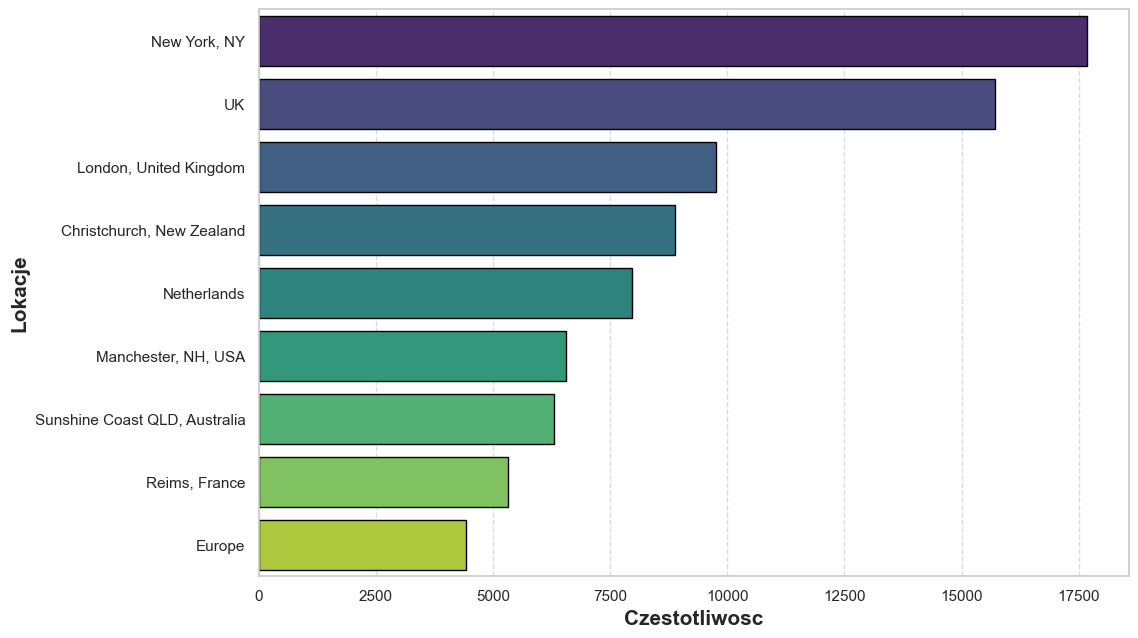

In [472]:
words = []
freq = []
for word, count in locations_sorted.values[:10]:
    words.append(word)
    freq.append(count)

# Set the style
sns.set(style="whitegrid")

# Create the barplot
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=freq, y=words, palette="viridis", edgecolor='black')

# Add titles and labels
# ax.set_title('Word Frequencies', fontsize=20, fontweight='bold')
ax.set_xlabel('Czestotliwosc', fontsize=15, fontweight='bold')
ax.set_ylabel('Lokacje', fontsize=15, fontweight='bold')

# Customize the grid
ax.grid(axis='x', linestyle='--', alpha=0.7)

# sns.barplot(x=freq, y=words)
# plt.title("Miasta z najwieksza liczba wpisow")
plt.show()


In [46]:
list(locations_sorted.loc[:30].locations)

[nan,
 'New York, NY',
 'UK',
 'London, United Kingdom',
 'Christchurch, New Zealand',
 'Netherlands',
 'Manchester, NH, USA',
 'Sunshine Coast QLD, Australia',
 'Reims, France',
 'Europe',
 'Australia',
 'Oxford, United Kingdom',
 'Pennsylvania',
 'London, UK',
 'Copenhagen, Denmark',
 'Dietzenbach, Deutschland',
 'Manchester, United Kingdom',
 'Waterloo, Canada',
 'Canada',
 'United Kingdom',
 'Colorado',
 'Germany',
 'Arabian Gulf',
 'Italia USA UK',
 'Berlin, Deutschland',
 'California',
 'Santa Cruz, CA, United States',
 'Kuwait',
 'Parts Unknown',
 'Washington, DC USA',
 'Ontario, Canada']


  
  
  PROPOZYCJE
  
  UK na UK London
  
  Netherlands na Netherlands Amsterdam (bo hague, amsterdam ,rotterdam mniej wiecej razem sie znajduja )
  
  Europe, Australia usuwam
  
 Canada na Canada Torronto
 
 'New York, NY',
 'London, United Kingdom',
 'Christchurch, New Zealand',
 'Netherlands, Amsterdam',
 'Manchester, NH, USA',
 'Sunshine Coast QLD, Australia',
 'Reims, France',
 'Oxford, United Kingdom',
 'Pennsylvania',
 'Copenhagen, Denmark',
 'Dietzenbach, Deutschland',
 'Manchester, United Kingdom',
 'Waterloo, Canada',
 'Canada, Torronto',
 'Colorado',
 'Germany, Berlin',
 'Arabian Gulf',
 'California',
 'Santa Cruz, CA, United States',
 'Kuwait',
 'Washington, DC USA',
 'Ontario, Canada'

New York, NY, USA: 40.7128° N, -74.0060° W
London, United Kingdom: 51.5074° N, -0.1278° W
Christchurch, New Zealand: -43.5321° S, 172.6362° E
Amsterdam, Netherlands: 52.3676° N, 4.9041° E
Manchester, NH, USA: 42.9956° N, -71.4548° W
Sunshine Coast QLD, Australia: -26.6500° S, 153.0667° E
Reims, France: 49.2583° N, 4.0317° E
Oxford, United Kingdom: 51.7520° N, -1.2577° W
Pennsylvania, USA: Approximately 40.8966° N, Approximately -77.8389° W
Copenhagen, Denmark: 55.6761° N, 12.5683° E
Dietzenbach, Deutschland: 50.0126° N, 8.7944° E
Manchester, United Kingdom: 53.4808° N, -2.2426° W
Waterloo, Canada: 43.4643° N, -80.5204° W
Toronto, Canada: 43.6511° N, -79.3832° W
Colorado, USA: Approximately 38.9972° N, Approximately -105.5478° W
Berlin, Germany: 52.5200° N, 13.4050° E
Arabian Gulf: Approximately 26.0000° N, Approximately 51.0000° E
California, USA: Approximately 36.7783° N, Approximately -119.4179° W
Santa Cruz, CA, United States: 36.9741° N, -122.0308° W
Kuwait: 29.3759° N, 47.9774° E
Washington, DC, USA: 38.9072° N, -77.0369° W
Ontario, Canada: Approximately 51.2538° N, Approximately -85.3232° W

22 lokacji

40.7128, -74.0060
51.5074,-0.1278
-43.5321,172.6362
52.3676,4.9041
42.9956,-71.4548
26.6500,153.0667
49.2583,4.0317
51.7520,-1.2577
40.8966,-77.8389
55.6761,12.5683
50.0126,8.7944
53.4808,-2.2426
43.4643,-80.5204
43.6511,-79.3832
38.9972,-105.5478
52.5200,13.4050
26.0000,51.0000
36.7783,-119.4179
36.9741,-122.0308
29.3759,47.977
38.9072,-77.0369
51.2538,-85.3232

In [47]:
# lets drop Europe/Australia/Parts Unknown etc...
weather_from_locations = ['New York, NY', 'London, United Kingdom', 'Christchurch, New Zealand', 'Netherlands, Amsterdam',
                          'Manchester, NH, USA', 'Sunshine Coast QLD, Australia', 'Reims, France', 'Oxford, United Kingdom',
                          'Pennsylvania', 'Copenhagen, Denmark', 'Dietzenbach, Deutschland', 'Manchester, United Kingdom',
                          'Waterloo, Canada', 'Canada, Torronto', 'Colorado', 'Germany, Berlin', 'Arabian Gulf', 'California',
                          'Santa Cruz, CA, United States', 'Kuwait', 'Washington, DC USA', 'Ontario, Canada']
len(weather_from_locations)

22

In [48]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [40.7128, 51.5074, -43.5321, 52.3676, 42.9956, 26.65, 49.2583, 51.752, 40.8966, 55.6761, 50.0126, 53.4808, 43.4643, 43.6511, 38.9972, 52.52, 26, 36.7783, 36.9741, 29.3759, 38.9072, 51.2538],
	"longitude": [-74.006, -0.1278, 172.6362, 4.9041, -71.4548, 153.0667, 4.0317, -1.2577, -77.8389, 12.5683, 8.7944, -2.2426, -80.5204, -79.3832, -105.5478, 13.405, 51, -119.4179, -122.0308, 47.977, -77.0369, -85.3232],
	"start_date": ["2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01", "2011-01-01"],
	"end_date": ["2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01", "2024-01-01"],
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "apparent_temperature"],
	"timezone": ["auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto", "auto"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
hourly_dataframes_ = []
for i in range(22):
    response = responses[i]
    print(f"Location {weather_from_locations[i]}")
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    
    
    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
    hourly_rain = hourly.Variables(3).ValuesAsNumpy()
    apparent_temperature = hourly.Variables(4).ValuesAsNumpy()
    
    hourly_data = {"date": pd.date_range(
    	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    	freq = pd.Timedelta(seconds = hourly.Interval()),
    	inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["apparent_temperature"] = apparent_temperature
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["rain"] = hourly_rain
    hourly_data["location"] = weather_from_locations[i]
    
    hourly_dataframe_ = pd.DataFrame(data = hourly_data)
    hourly_dataframes_.append(hourly_dataframe_)

Location New York, NY
Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 32.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s
Location London, United Kingdom
Coordinates 51.49384689331055°N -0.16302490234375°E
Elevation 16.0 m asl
Timezone b'Europe/London' b'BST'
Timezone difference to GMT+0 3600 s
Location Christchurch, New Zealand
Coordinates -43.550086975097656°N 172.69174194335938°E
Elevation 9.0 m asl
Timezone b'Pacific/Auckland' b'NZST'
Timezone difference to GMT+0 43200 s
Location Netherlands, Amsterdam
Coordinates 52.337432861328125°N 4.833333492279053°E
Elevation 5.0 m asl
Timezone b'Europe/Amsterdam' b'CEST'
Timezone difference to GMT+0 7200 s
Location Manchester, NH, USA
Coordinates 42.98769760131836°N -71.41159057617188°E
Elevation 80.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s
Location Sunshine Coast QLD, Australia
Coordinates 26.678380966186523°N 153.04971313476562°E
Elevation 0.0 m asl
Tim

In [473]:
hourly_dataframes_all = pd.concat(hourly_dataframes_)
hourly_dataframes_all['date'] = hourly_dataframes_all['date'].dt.tz_localize(None)
hourly_dataframes_all.head(1)

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,location
0,2011-01-01 04:00:00,-0.743,91.914703,-4.35181,0.0,0.0,"New York, NY"


In [474]:
# weather_pres = hourly_dataframes_all.copy()
# weather_pres.rename ()

In [50]:
# teraz polaczyc dane pogodowe z tekstami
all_texts.head(1)

,CreationDate,Text,Title,Tags,Location
0,2011-06-21 20:00:00,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,<caribbean><cruising><vacations>,"Toronto, Canada"


In [51]:
# lets rename some locations from all_texts
all_texts_changed_locations = all_texts.copy()
all_texts_changed_locations.loc[all_texts_changed_locations.Location == "UK", "Location"] = "London, United Kingdom"
all_texts_changed_locations.loc[all_texts_changed_locations.Location == "London, UK", "Location"] = "London, United Kingdom"
all_texts_changed_locations.loc[all_texts_changed_locations.Location == "United Kingdom", "Location"] = "London, United Kingdom"
all_texts_changed_locations.loc[all_texts_changed_locations.Location == "Netherlands", "Location"] = "Netherlands, Amsterdam"
all_texts_changed_locations.loc[all_texts_changed_locations.Location == "Canada", "Location"] = "Canada, Torronto"
all_texts_changed_locations.loc[all_texts_changed_locations.Location == "Berlin, Deutschland", "Location"] = "Germany, Berlin"

In [52]:
all_texts_changed_locations.head(1)

,CreationDate,Text,Title,Tags,Location
0,2011-06-21 20:00:00,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,<caribbean><cruising><vacations>,"Toronto, Canada"


In [53]:
merged_weather_texts = all_texts_changed_locations.merge(hourly_dataframes_all, how = "inner", left_on = ["CreationDate", "Location"], 
                                                                        right_on = ["date", "location"])
merged_weather_texts.drop(["Location", "CreationDate"], axis = 1, inplace = True)
merged_weather_texts["temperature_mean"] = (merged_weather_texts.temperature_2m + merged_weather_texts.apparent_temperature) / 2
merged_weather_texts.head(1)

,Text,Title,Tags,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,location,temperature_mean
0,<p>Singapore Airlines has an all-business clas...,Does Singapore Airlines offer any reward seats...,<loyalty-programs><routes><ewr><singapore-airl...,2011-06-21 20:00:00,26.357,61.469131,28.947426,0.0,0.0,"New York, NY",27.652214


In [54]:
merged_weather_texts.shape

(127619, 11)

In [477]:
data_for_clustering = merged_weather_texts[["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation"]]
data_for_clustering_precipitation = merged_weather_texts[["precipitation"]]
data_for_clustering.head(1)

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation
0,26.357,61.469131,28.947426,0.0


In [478]:
print(data_for_clustering.describe())

       temperature_2m  relative_humidity_2m  apparent_temperature  \
count   127619.000000         127619.000000         127619.000000   
mean        13.730262             70.141724             11.657081   
std          9.458899             18.498163             11.426393   
min        -39.251999              4.718862            -44.585323   
25%          7.405500             57.820992              3.644807   
50%         13.714500             72.761620             11.474943   
75%         20.002001             85.003582             19.088480   
max         48.834499            100.000000             48.658913   

       precipitation  
count  127619.000000  
mean        0.099375  
std         0.408110  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        15.300000  


In [483]:
data_for_clustering.rename(columns = {"temperature_2m":"Temperatura", \
                                     "relative_humidity_2m":"Wilgontosc", \
                                     "apparent_temperature":"Temperatura Odczuwalna", \
                                     "precipitation":"Opady"}, inplace=True)

In [ ]:
# cluster_below_0 = merged_weather_texts_preprocessed[merged_weather_texts_preprocessed.temperature_mean <= 0] \
#                     .reset_index().drop(columns = "index")
# cluster_0_26 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.temperature_mean > 0) & (merged_weather_texts_preprocessed.temperature_mean < 26)] \
#                     .reset_index().drop(columns = "index")
# cluster_above_26 = merged_weather_texts_preprocessed[merged_weather_texts_preprocessed.temperature_mean >= 26] \
#                     .reset_index().drop(columns = "index")

# cluster_relative_humidity_2m_30 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.relative_humidity_2m <= 30)] \
#                     .reset_index().drop(columns = "index")
# cluster_relative_humidity_2m_90 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.relative_humidity_2m >= 90)] \
#                     .reset_index().drop(columns = "index")

# cluster_precipitation_0 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.precipitation == 0)] \
#                     .reset_index().drop(columns = "index")
# cluster_precipitation_5 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.precipitation >= 5)] \
#                     .reset_index().drop(columns = "index")

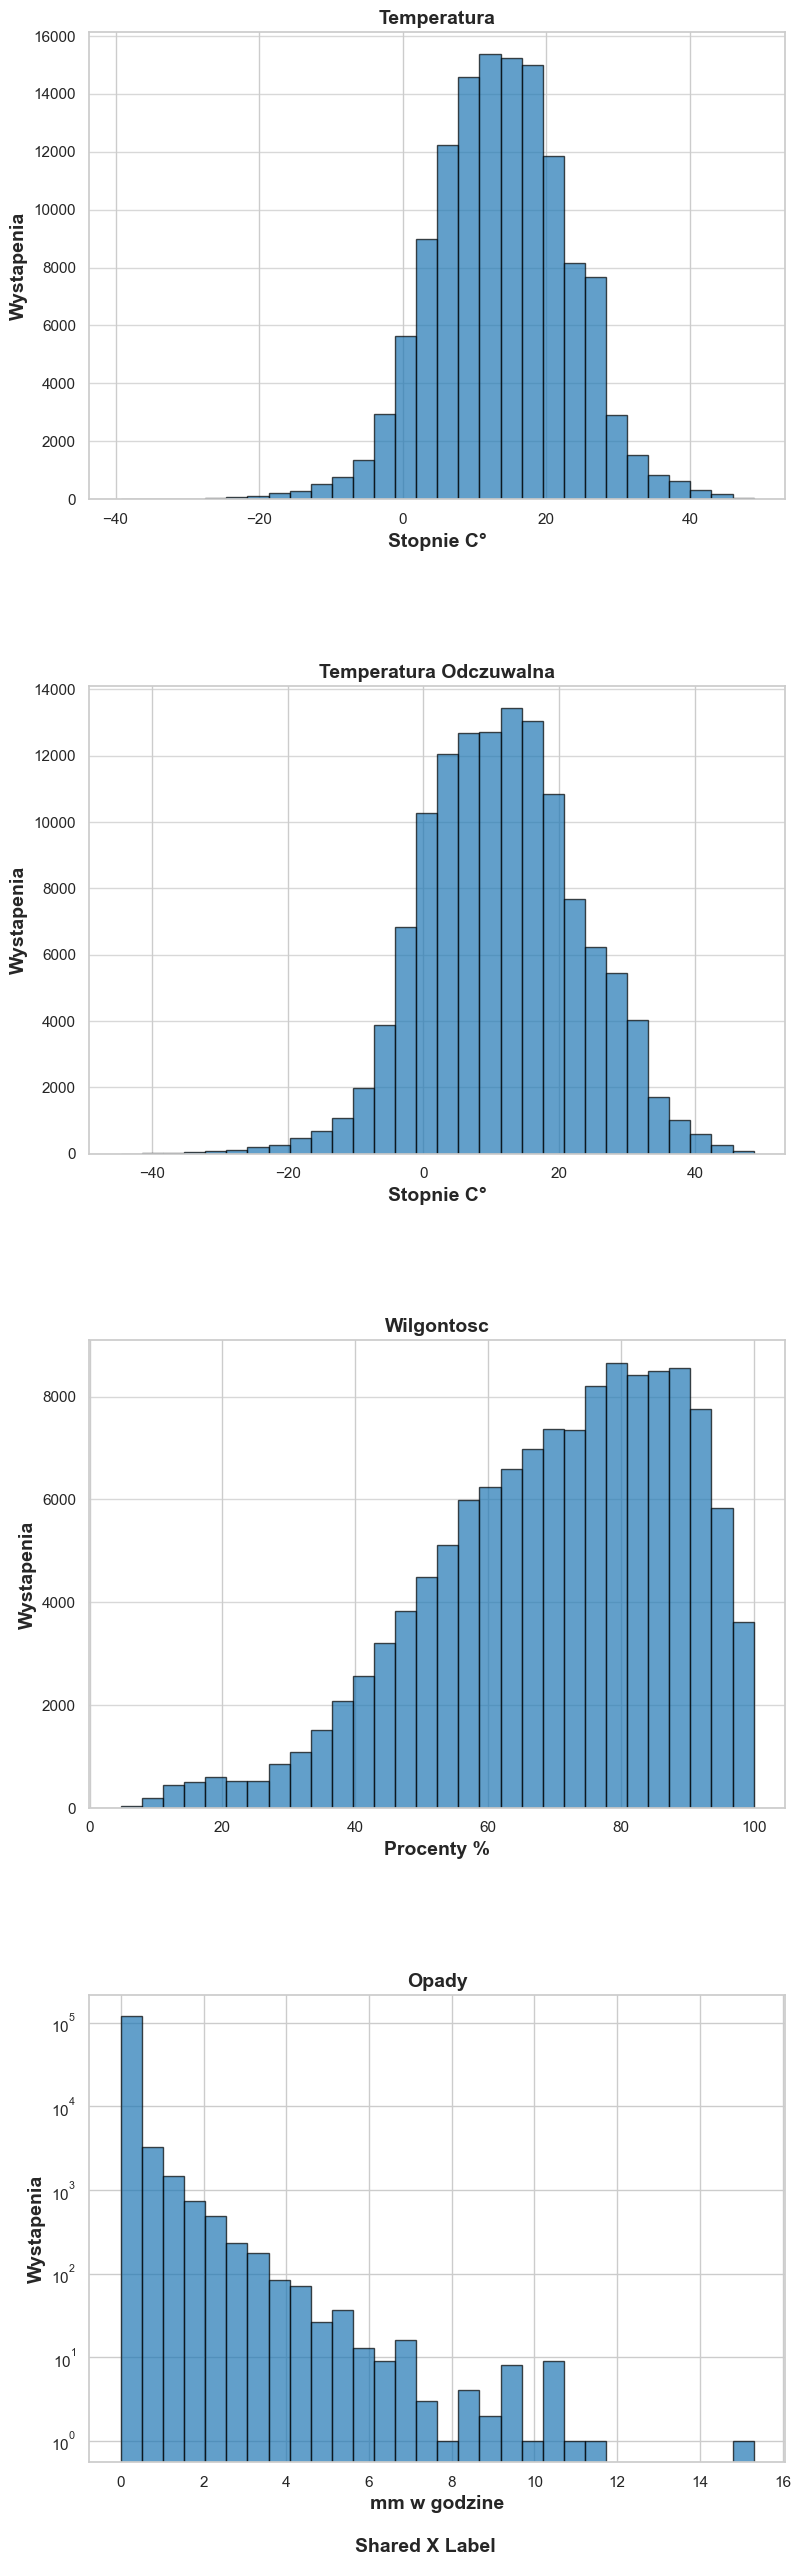

In [508]:
# # Histograms
# data_for_clustering.hist(figsize=(10, 6), bins = 30)
# # plt.hist(data_for_clustering, bins=30, edgecolor='black', alpha=0.7, color=['#1f77b4' for i in range(4)])
# plt.suptitle('Histograms of WeatherData')
# plt.show()
# 5) podzielic na grupy wpisy wedlug podobnej pogody
fig, axes = plt.subplots(4, 1, figsize=(8, 30))
fig.subplots_adjust(hspace=0.4)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the columns and create a histogram for each
# for i, col in enumerate(data_for_clustering.columns):
ax = axes[0]
data_for_clustering["Temperatura"].hist(bins=30, edgecolor='black', alpha=0.7, color='#1f77b4', ax=ax)
ax.set_title("Temperatura", fontsize=14, fontweight='bold')
ax.set_xlabel("Stopnie C\u00B0", fontsize=14, fontweight='bold')
ax.set_ylabel("Wystapenia", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.75)

ax = axes[1]
data_for_clustering["Temperatura Odczuwalna"].hist(bins=30, edgecolor='black', alpha=0.7, color='#1f77b4', ax=ax)
ax.set_title("Temperatura Odczuwalna", fontsize=14, fontweight='bold')
ax.set_xlabel("Stopnie C\u00B0", fontsize=14, fontweight='bold')
ax.set_ylabel("Wystapenia", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.75)

fig.text(0.5, 0.04, 'Shared X Label', ha='center', fontsize=14, fontweight='bold')

ax = axes[2]
data_for_clustering["Wilgontosc"].hist(bins=30, edgecolor='black', alpha=0.7, color='#1f77b4', ax=ax)
ax.set_title("Wilgontosc", fontsize=14, fontweight='bold')
ax.set_xlabel("Procenty %", fontsize=14, fontweight='bold')
ax.set_ylabel("Wystapenia", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.75)


ax = axes[3]
data_for_clustering["Opady"].hist(bins=30, edgecolor='black', alpha=0.7, color='#1f77b4', ax=ax)
ax.set_title("Opady", fontsize=14, fontweight='bold')
ax.set_xlabel('mm w godzine', fontsize=14, fontweight='bold')
ax.set_ylabel('Wystapenia', fontsize=14, fontweight='bold')
plt.yscale("log")


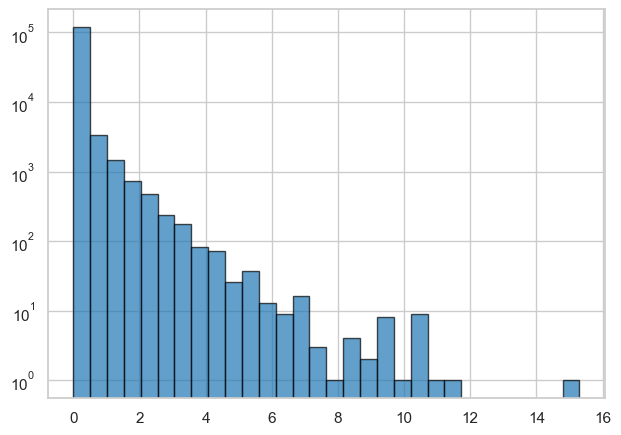

In [487]:
data_for_clustering["Opady"].hist(bins=30, edgecolor='black', alpha=0.7, color='#1f77b4')
ax.set_title("Opady", fontsize=14, fontweight='bold')
ax.set_xlabel('Value', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
plt.yscale("log")

In [60]:
# normal distribution of temperature wheather
# let divide into gropus (below 0, 0 - 20, above 20)

In [61]:
from tqdm import tqdm
from tqdm import trange
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [62]:
preprocessor = Pipeline(
     [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
     ]
)

In [63]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=3,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [64]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [65]:
data_for_clustering = data_for_clustering.values 

In [66]:
pipe.fit(data_for_clustering)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

In [67]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data_for_clustering),
    columns=["component_1", "component_2"],
)
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf

,component_1,component_2,predicted_cluster
0,0.193501,-0.159906,2
1,0.189117,-0.160253,2
2,0.189117,-0.160253,2
3,0.189117,-0.160253,2
4,-0.014163,-0.228400,1
...,...,...,...
127614,-0.334028,0.061588,1
127615,0.030647,-0.010993,1
127616,0.030647,-0.010993,1
127617,0.206362,0.004795,2


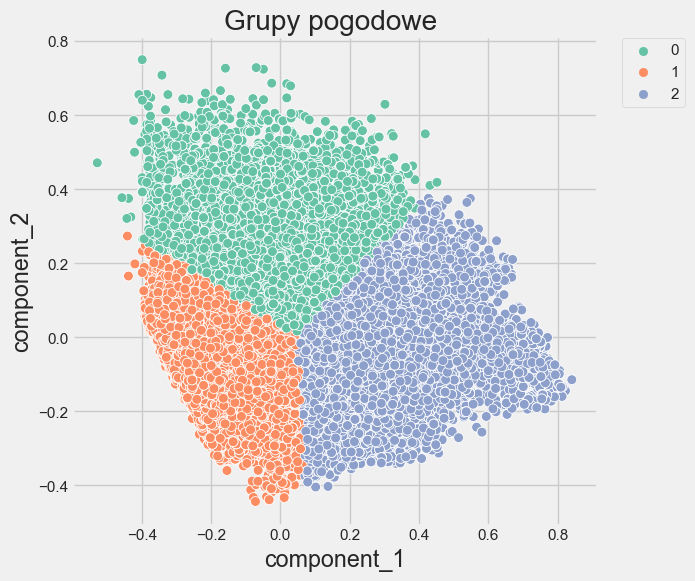

In [516]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data_for_clustering),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))

scat = sns.scatterplot(
    x = "component_1",
    y = "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    palette="Set2",
)
sns.despine(left=True, bottom=True)


scat.set_title(
    "Grupy pogodowe "
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [69]:
# iris = load_iris()
# X = iris.data
# y = iris.target

# # Perform PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Inverse transform the PCA data
# X_original = pca.inverse_transform(X_pca)

# # Create a DataFrame with the original data
# df_original = pd.DataFrame(X_original, columns=iris.feature_names)

# # Visualize the data
# sns.pairplot(df_original)
# plt.suptitle('Data in Original Feature Space')
# plt.show()

In [ ]:
# texts preprocessing 

In [546]:
merged_weather_texts_preprocessed = merged_weather_texts.copy()

In [547]:
import textwrap

presentation_ex = merged_weather_texts_preprocessed["Text"][1]
print(textwrap.fill(presentation_ex, width=50))

<p>An american software engineer living in Japan
gives a <a
href="http://www.kalzumeus.com/2011/03/13/some-
perspective-on-the-japan-earthquake/"
rel="noreferrer">good overview of how big Japan
is</a> and why you shouldn't be afraid to travel
there after the nuclear accident.</p>
<p>Essentially, the summary is that Japan is very
large. It's unlikely that your travel plans as a
tourist will be anywhere near the accident.</p>
<p>Source: <a
href="http://mapfrappe.com/index.html?show=3057" r
el="noreferrer">http://mapfrappe.com/index.html?sh
ow=3057</a><img
src="https://i.stack.imgur.com/plen2.png"
alt="enter image description here"></p>


In [548]:
show_me_Text_col(merged_weather_texts_preprocessed, "Text")

Comment 0

<p>Singapore Airlines has an all-business class flight from EWR-SIN (Newark->Singapore), but I can't seem to find any reward Krisflyer flights for <em>any</em> dates.  </p>

Comment 1

<p>An american software engineer living in Japan gives a <a href="http://www.kalzumeus.com/2011/03/13/some-perspective-on-the-japan-earthquake/" rel="noreferrer">good overview of how big Japan is</a> and why you shouldn't be afraid to travel there after the nuclear accident.</p>

<p>Essentially, the summary is that Japan is very large. It's unlikely that your travel plans as a tourist will be anywhere near the accident.</p>

<p>Source: <a href="http://mapfrappe.com/index.html?show=3057" rel="noreferrer">http://mapfrappe.com/index.html?show=3057</a><img src="https://i.stack.imgur.com/plen2.png" alt="enter image description here"></p>

Comment 2

<p>As an American who just recently traveled to Israel for the first time with a former Israeli, my impression is that you should stay in Jerusalem.</p

In [549]:
merged_weather_texts_preprocessed.Text

0         <p>Singapore Airlines has an all-business clas...
1         <p>An american software engineer living in Jap...
2         <p>As an American who just recently traveled t...
3         <p>If I book a trip such as JFK-SIN-MLE (New Y...
4         <p>I have verified that you can upgrade two se...
                                ...                        
127614    After 90 days can I move to Portugal to avoid ...
127615    @DanubianSailor I think the preferred path wou...
127616    This from the DHS website help section - *Can ...
127617                 Thanks, this is a super-useful link!
127618    Can you provide a citation for the definition ...
Name: Text, Length: 127619, dtype: object

In [550]:
from bs4 import BeautifulSoup
import re

def clean_from_html_syntax(text):
    soup = BeautifulSoup(str(text), 'html.parser')
    text = soup.get_text()
    cleaned_text = re.sub(r'\s+', ' ', text) 
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    cleaned_text = cleaned_text.lower() 
    return cleaned_text


tqdm.pandas(desc="Processing Rows")
merged_weather_texts_preprocessed["OriginalText"] = merged_weather_texts_preprocessed["Text"]
merged_weather_texts_preprocessed["Text"] = merged_weather_texts_preprocessed["Text"].progress_apply(clean_from_html_syntax)

Processing Rows: 100%|████████████████| 127619/127619 [00:25<00:00, 5082.84it/s]


In [551]:
show_me_Text_col(merged_weather_texts_preprocessed, "Text")

Comment 0

singapore airlines has an allbusiness class flight from ewrsin newarksingapore but i cant seem to find any reward krisflyer flights for any dates 
Comment 1

an american software engineer living in japan gives a good overview of how big japan is and why you shouldnt be afraid to travel there after the nuclear accident essentially the summary is that japan is very large its unlikely that your travel plans as a tourist will be anywhere near the accident source httpmapfrappecomindexhtmlshow3057 
Comment 2

as an american who just recently traveled to israel for the first time with a former israeli my impression is that you should stay in jerusalem we took a bus that only took about 45 minutes from tel aviv to jerusalem they are very close together and jerusalem was much more interesting to me from a tourist perspective ie the rich history and architecture 
Comment 3

if i book a trip such as jfksinmle new york  singapore  maldives rt round trip would it be possible to use miles

In [552]:
import nltk

In [553]:
from nltk.tokenize import word_tokenize
merged_weather_texts_preprocessed.Text = merged_weather_texts_preprocessed.Text.progress_apply(word_tokenize)

Processing Rows: 100%|████████████████| 127619/127619 [00:50<00:00, 2523.71it/s]


In [554]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
merged_weather_texts_preprocessed.Text = merged_weather_texts_preprocessed.Text.progress_apply(lambda x: [word for word in x if word not in stop_words])



[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing Rows: 100%|███████████████| 127619/127619 [00:02<00:00, 53521.79it/s]


In [555]:
# lematyzacja/stemming
# !pip install -q pymorphy2

In [556]:
# !pip install spacy

In [557]:
# !python -m spacy download en_core_web_sm

In [558]:
# na poczatku probowalem zrobic lemmatization przy pomocy
# spacy ale zajmowalo to duzo czasu (okolo 5 godzin)?

In [559]:
# import spacy
# lemmatizer = spacy.load("en_core_web_sm")

# def lemmatize_tokens(tokens):
#     lemmas = [lemmatizer(token) for token in tokens]
#     return lemmas

In [560]:
# potem znalazlem inne szybsze rozwiazanie:)
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/admin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [561]:
wnl = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    lemmas = [wnl.lemmatize(token, pos="v") for token in tokens]
    return lemmas

In [562]:
merged_weather_texts_preprocessed["Text_lemma"] = merged_weather_texts_preprocessed.Text.progress_apply(lemmatize_tokens)

Processing Rows: 100%|████████████████| 127619/127619 [00:34<00:00, 3655.40it/s]


In [563]:
merged_weather_texts_preprocessed.head(1)

,Text,Title,Tags,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,location,temperature_mean,OriginalText,Text_lemma
0,"[singapore, airlines, allbusiness, class, flig...",Does Singapore Airlines offer any reward seats...,<loyalty-programs><routes><ewr><singapore-airl...,2011-06-21 20:00:00,26.357,61.469131,28.947426,0.0,0.0,"New York, NY",27.652214,<p>Singapore Airlines has an all-business clas...,"[singapore, airlines, allbusiness, class, flig..."


In [564]:
def joinTextFun(lst):
    res = " ".join(lst)
    return res
merged_weather_texts_preprocessed["PreprocessedText"] = merged_weather_texts_preprocessed["Text_lemma"].progress_apply(joinTextFun)

Processing Rows: 100%|██████████████| 127619/127619 [00:00<00:00, 383543.19it/s]


In [565]:
import textwrap

presentation_ex = merged_weather_texts_preprocessed["PreprocessedText"][1][:-33]
print(textwrap.fill(presentation_ex, width=50))

american software engineer live japan give good
overview big japan shouldnt afraid travel nuclear
accident essentially summary japan large unlikely
travel plan tourist anywhere near accident source


In [566]:
merged_weather_texts_preprocessed.shape

(127619, 14)

In [567]:
cluster_below_0 = merged_weather_texts_preprocessed[merged_weather_texts_preprocessed.temperature_mean <= 0] \
                    .reset_index().drop(columns = "index")
cluster_0_26 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.temperature_mean > 0) & (merged_weather_texts_preprocessed.temperature_mean < 26)] \
                    .reset_index().drop(columns = "index")
cluster_above_26 = merged_weather_texts_preprocessed[merged_weather_texts_preprocessed.temperature_mean >= 26] \
                    .reset_index().drop(columns = "index")

cluster_relative_humidity_2m_30 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.relative_humidity_2m <= 30)] \
                    .reset_index().drop(columns = "index")
cluster_relative_humidity_2m_90 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.relative_humidity_2m >= 90)] \
                    .reset_index().drop(columns = "index")

cluster_precipitation_0 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.precipitation == 0)] \
                    .reset_index().drop(columns = "index")
cluster_precipitation_5 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.precipitation >= 5)] \
                    .reset_index().drop(columns = "index")

In [568]:
cluster_precipitation_5.shape, cluster_precipitation_0.shape, cluster_relative_humidity_2m_90.shape, \
cluster_relative_humidity_2m_30.shape, cluster_above_26.shape, cluster_0_26.shape, cluster_below_0.shape

((114, 14),
 (106423, 14),
 (18512, 14),
 (3635, 14),
 (13846, 14),
 (101006, 14),
 (12767, 14))

In [569]:
def get_corpus_most_common_n(df, n=10):
    corpus = []
    for i in trange(df.shape[0], colour='green'):
        corpus += df['Text_lemma'][i]
    mostCommon = Counter(corpus).most_common(n)
    return mostCommon

In [570]:
# na poczatku dla calego dataset
mostCommon = get_corpus_most_common_n(merged_weather_texts_preprocessed)

100%|███████████████████████████████| 127619/127619 [00:01<00:00, 118298.02it/s]


In [571]:
mostCommon_0 = get_corpus_most_common_n(cluster_below_0)
mostCommon_0_26 = get_corpus_most_common_n(cluster_0_26)
mostCommon_26 = get_corpus_most_common_n(cluster_above_26)

mostCommon_relative_humidity_2m_30 = get_corpus_most_common_n(cluster_relative_humidity_2m_30)
mostCommon_relative_humidity_2m_90 = get_corpus_most_common_n(cluster_relative_humidity_2m_90)


mostCommon_precipitation_0 = get_corpus_most_common_n(cluster_precipitation_0)
mostCommon_precipitation_5 = get_corpus_most_common_n(cluster_precipitation_5)


100%|██████████████████████████████████████| 114/114 [00:00<00:00, 52222.66it/s]


In [572]:
show_me_Text_col(cluster_precipitation_5, "Text_lemma", i=10, n=10)

Comment 0

['go', 'problems', 'giacomo', 'catenazzi', 'say', 'sell', 'property', 'pay', 'trip', 'bite', 'red', 'flag', 'fact', 'large', 'amount', 'money', 'suddenly', 'appear', 'account', 'account', 'someone', 'pay', 'trip', 'go', 'red', 'flag', 'make', 'sure', 'documentation', 'sale', 'rock', 'solid', 'legal', 'document', 'show', 'detail', 'sale', 'much', 'documentation', 'raise', 'agents', 'definitely', 'make', 'thorough', 'check', 'document', 'father', 'pay', 'trip', 'absolutely', 'must', 'include', 'information', 'finance', 'need', 'know', 'afford', 'make', 'payments', 'land', 'sale', 'isnt', 'enough', 'maybe', 'debts', 'need', 'pay', 'land', 'sale', 'business', 'didnt', 'use', 'bank', 'account', 'need', 'find', 'way', 'show', 'save', 'regular', 'income', 'afford', 'payments', 'maybe', 'tax', 'statements', 'account', 'business', 'say', 'father', 'didnt', 'use', 'bank', 'account', 'save', 'put', 'save', 'money', 'land', 'sale', 'father', 'account', 'thing', 'account', 'thats', 'go',

In [573]:
count_visa_word = 0
last_visa_comment = 0
for i in range(cluster_precipitation_5.shape[0]):
    visa_occurancies = cluster_precipitation_5.Text_lemma[i].count("visa")
    count_visa_word += visa_occurancies
    if visa_occurancies > 0:
        last_visa_comment = i
last_visa_comment

94

In [574]:
cluster_precipitation_5.Text_lemma[94]

['interest',
 'tip',
 'get',
 'visa',
 'theres',
 'embassy',
 'ones',
 'country',
 'residencehttpstravelstackexchangecomquestions3455',
 'also',
 'see',
 'passport',
 'lose',
 'home',
 'country',
 'diplomatic',
 'presencehttpstravelstackexchangecoma835311480']

In [575]:
def plot_barplot_for_mostcommom(mostCommon, title):
    words = []
    freq = []
    for word, count in mostCommon:
        words.append(word)
        freq.append(count)
    sns.set_style("white")
    sns.barplot(x=freq, y=words)
    sns.barplot(
    x=freq, 
    y=words,  
    ci=None,        # Disable confidence intervals for a cleaner look
    palette='viridis',  # Choose a color palette
    # edgecolor='darkgrey'  # Set edge color for better contrast
)
    sns.despine(left=True, bottom=True)
    plt.title("")
    plt.show()

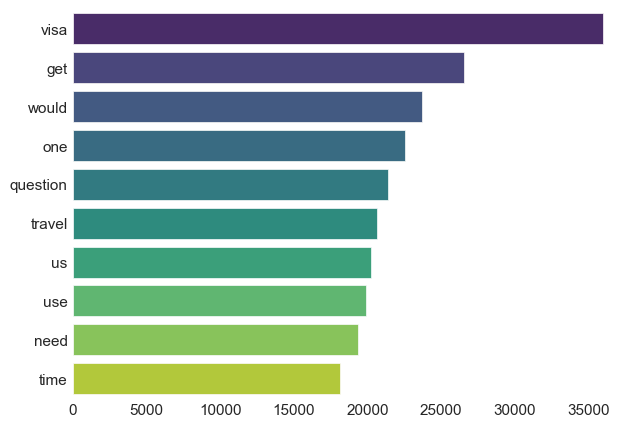

In [578]:
plot_barplot_for_mostcommom(mostCommon, "")

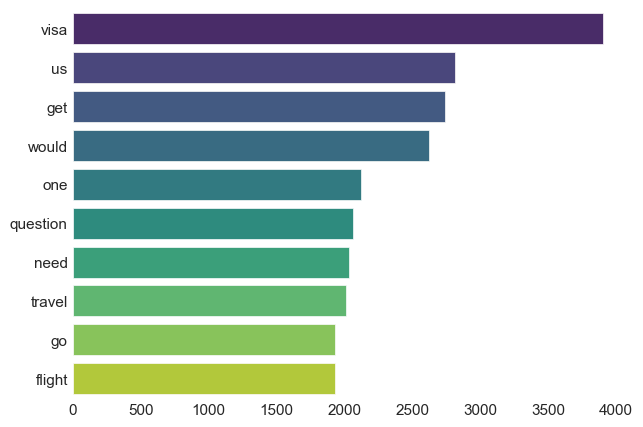

In [579]:
plot_barplot_for_mostcommom(mostCommon_0, "most common for below 0")

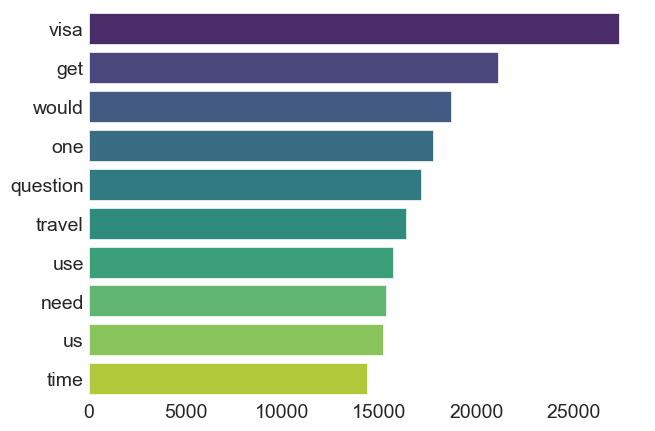

In [387]:
plot_barplot_for_mostcommom(mostCommon_0_26, "most common for 0-20")

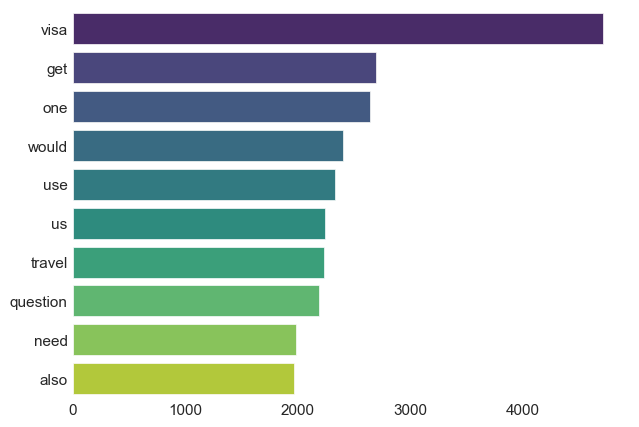

In [581]:
plot_barplot_for_mostcommom(mostCommon_26, "most common for above 20")

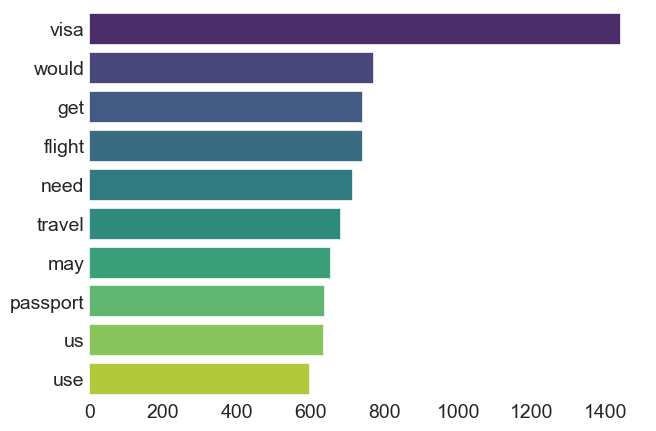

In [389]:
plot_barplot_for_mostcommom(mostCommon_relative_humidity_2m_30, "most common for above 20")

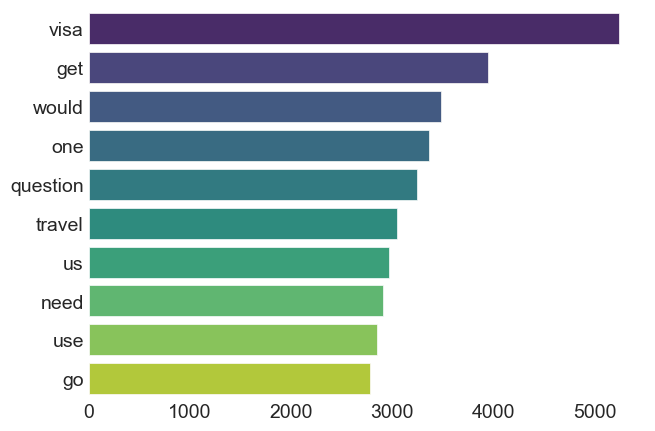

In [390]:
plot_barplot_for_mostcommom(mostCommon_relative_humidity_2m_90, "most common for above 20")

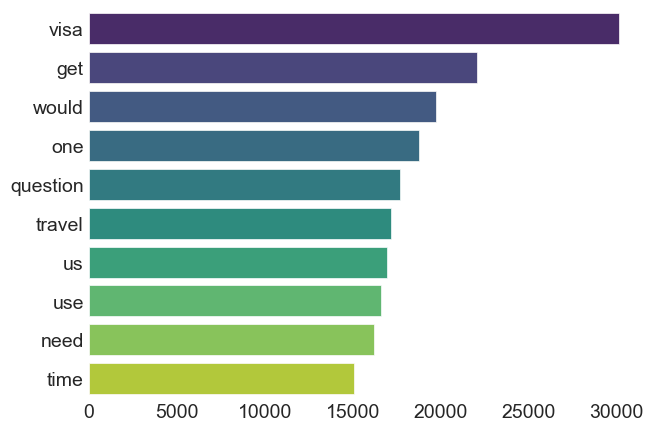

In [397]:
plot_barplot_for_mostcommom(mostCommon_precipitation_0, "most common for above 20")

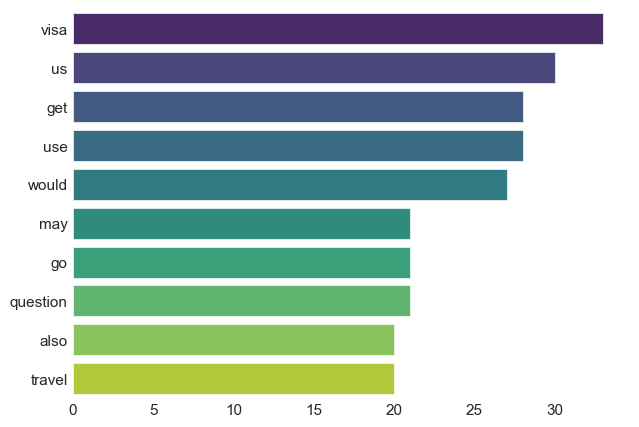

In [580]:
plot_barplot_for_mostcommom(mostCommon_precipitation_5, "most common for above 20")

In [399]:
mostCommon_precipitation_5

[('visa', 33),
 ('us', 30),
 ('get', 28),
 ('use', 28),
 ('would', 27),
 ('may', 21),
 ('go', 21),
 ('question', 21),
 ('also', 20),
 ('travel', 20)]

In [400]:
from nltk import FreqDist

def get_most_common_ngrams(df, n_gram=2, most_c=10):
    ngrams = []
    for i in trange(df.shape[0], colour="green"):
        ngrams += list(nltk.ngrams(df.Text[i], n_gram))
    most_common = FreqDist(ngrams).most_common(most_c)
    # zmieniam tuples z ngrams na string
    most_common_collocations = []
    for ngrams, cnt in most_common:
        most_common_collocations.append((" ".join(ngrams), cnt))
    return most_common_collocations

In [401]:
most_common_2grams_0 = get_most_common_ngrams(cluster_below_0)
most_common_2grams_0_26 = get_most_common_ngrams(cluster_0_26)
most_common_2grams_26 = get_most_common_ngrams(cluster_above_26)

mostCommon_2grams_relative_humidity_2m_30 = get_most_common_ngrams(cluster_relative_humidity_2m_30)
mostCommon_2grams_relative_humidity_2m_90 = get_most_common_ngrams(cluster_relative_humidity_2m_90)


mostCommon_2grams_precipitation_0 = get_most_common_ngrams(cluster_precipitation_0)
mostCommon_2grams_precipitation_5 = get_most_common_ngrams(cluster_precipitation_5)

100%|██████████████████████████████████████| 114/114 [00:00<00:00, 55989.54it/s]


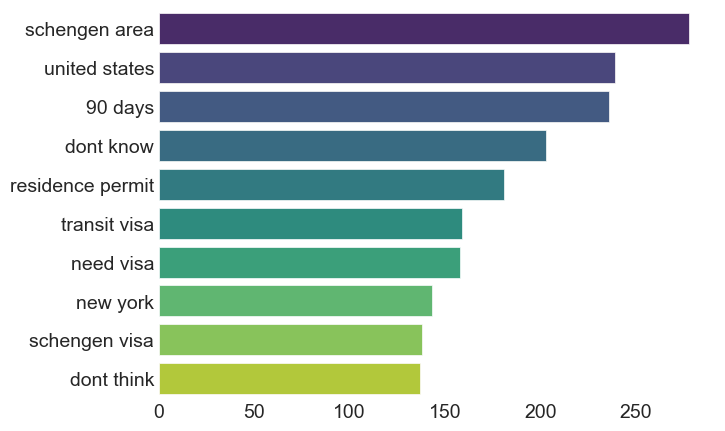

In [402]:
plot_barplot_for_mostcommom(most_common_2grams_0, title="most common 2grams below 0")

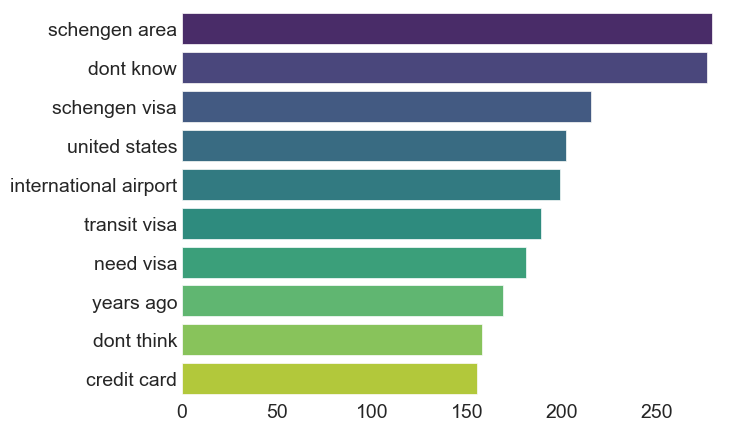

In [403]:
plot_barplot_for_mostcommom(most_common_2grams_26, title="most common 2grams 26")

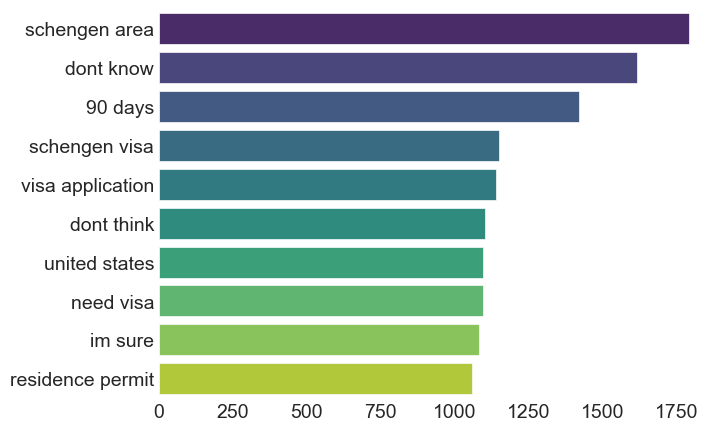

In [404]:
plot_barplot_for_mostcommom(most_common_2grams_0_26, title="most common 2grams 0-26")

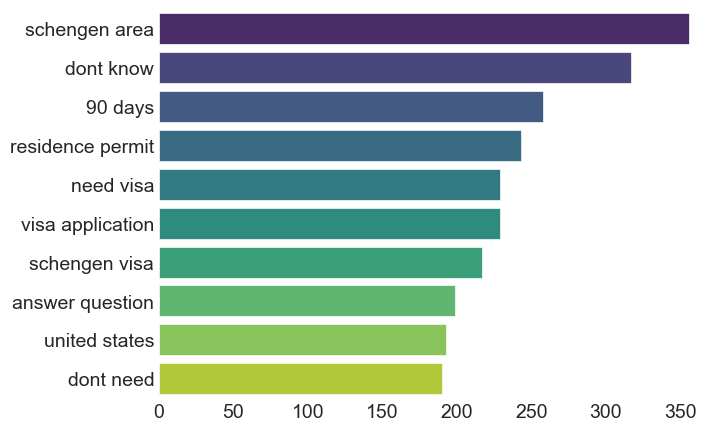

In [405]:
plot_barplot_for_mostcommom(mostCommon_2grams_relative_humidity_2m_90, title="")

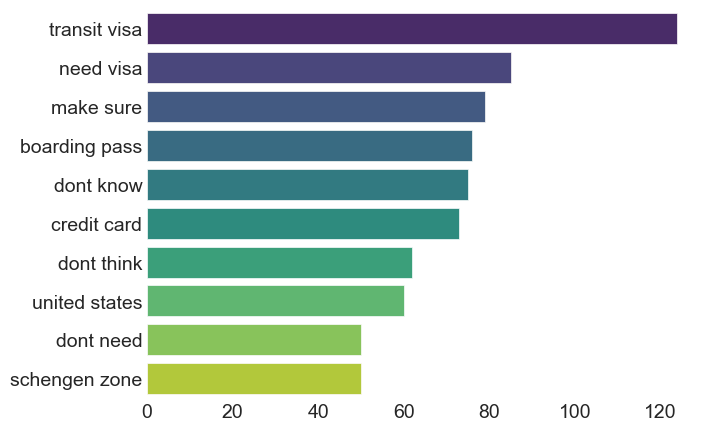

In [406]:
plot_barplot_for_mostcommom(mostCommon_2grams_relative_humidity_2m_30, title="")

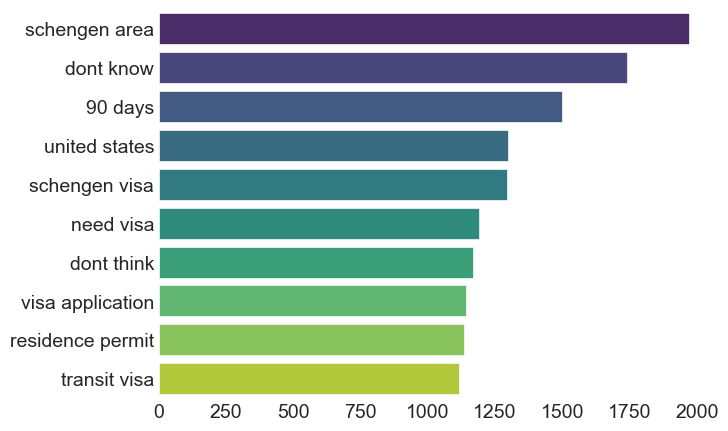

In [407]:
plot_barplot_for_mostcommom(mostCommon_2grams_precipitation_0, title="most common 2grams for precipitation_0")

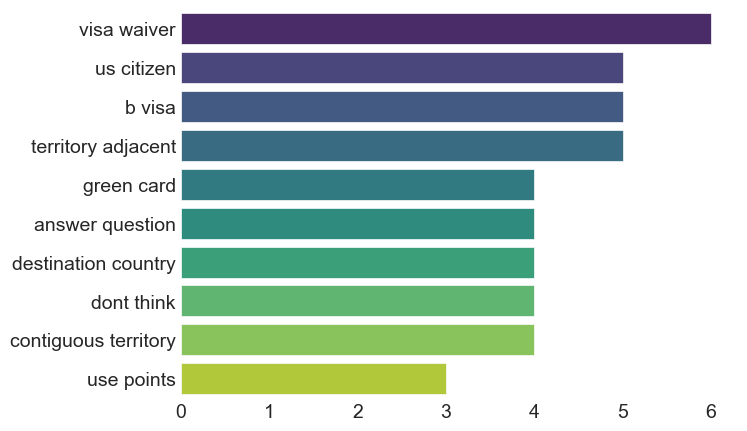

In [408]:
plot_barplot_for_mostcommom(mostCommon_2grams_precipitation_5, title="most common 2grams precipitation_5")

In [409]:
most_common_3grams_0 = get_most_common_ngrams(cluster_below_0,3 )
most_common_3grams_0_26 = get_most_common_ngrams(cluster_0_26, 3)
most_common_3grams_26 = get_most_common_ngrams(cluster_above_26, 3)

mostCommon_3grams_relative_humidity_2m_30 = get_most_common_ngrams(cluster_relative_humidity_2m_30, 3)
mostCommon_3grams_relative_humidity_2m_90 = get_most_common_ngrams(cluster_relative_humidity_2m_90, 3)


mostCommon_3grams_precipitation_0 = get_most_common_ngrams(cluster_precipitation_0, 3)
mostCommon_3grams_precipitation_5 = get_most_common_ngrams(cluster_precipitation_5, 3)

100%|██████████████████████████████████████| 114/114 [00:00<00:00, 45690.46it/s]


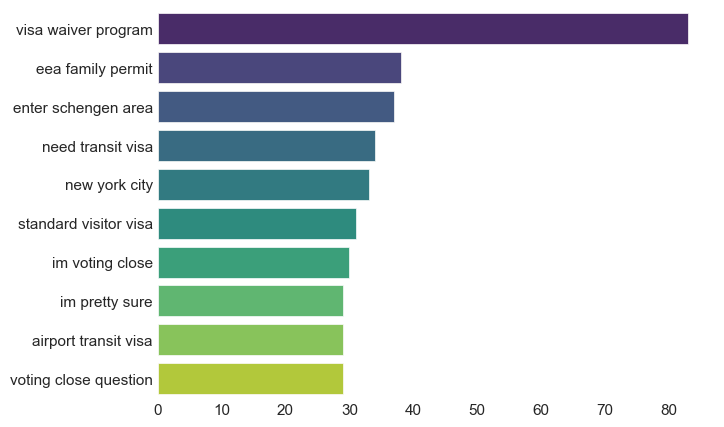

In [583]:
plot_barplot_for_mostcommom(most_common_3grams_0, title="most common 2grams 26")

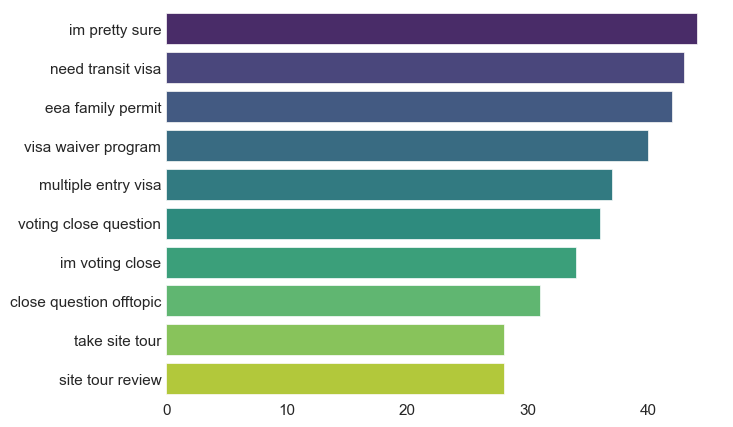

In [584]:
plot_barplot_for_mostcommom(most_common_3grams_26, title="most common 2grams 26")

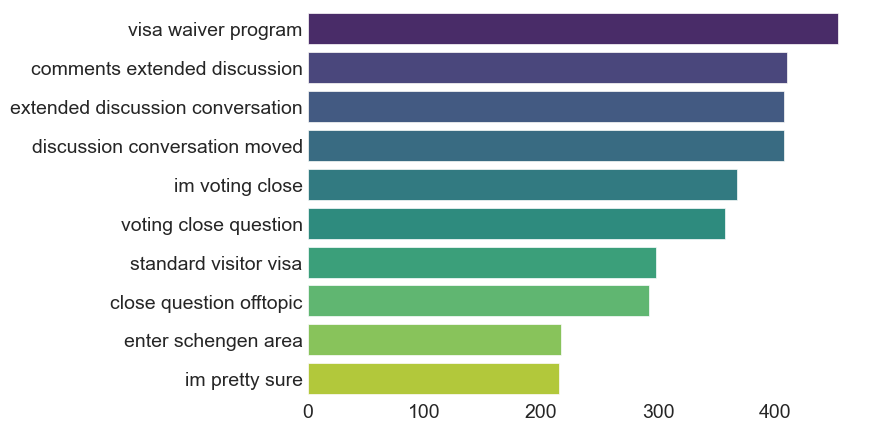

In [412]:
plot_barplot_for_mostcommom(most_common_3grams_0_26, title="most common 2grams 26")

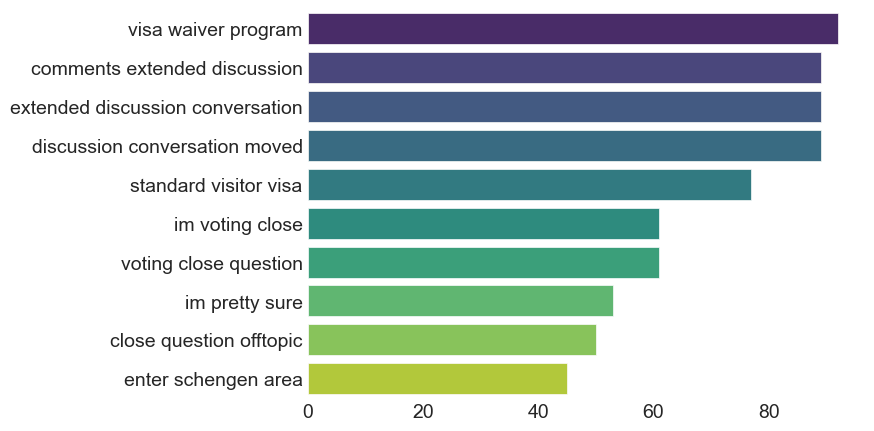

In [413]:
plot_barplot_for_mostcommom(mostCommon_3grams_relative_humidity_2m_90, title="")

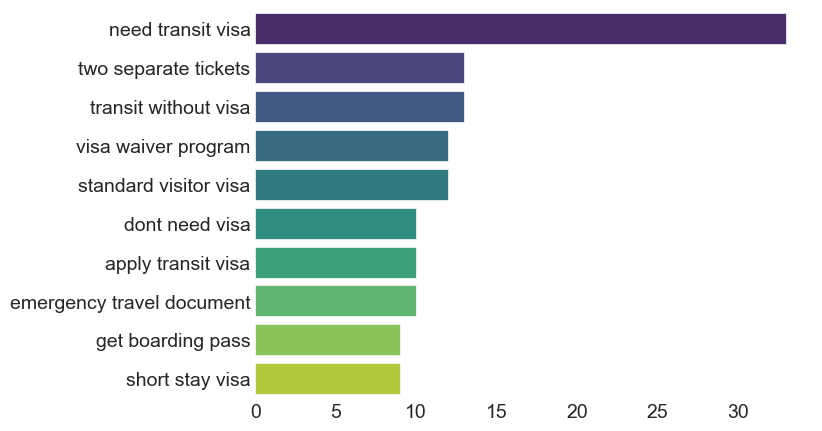

In [414]:
plot_barplot_for_mostcommom(mostCommon_3grams_relative_humidity_2m_30, title="")

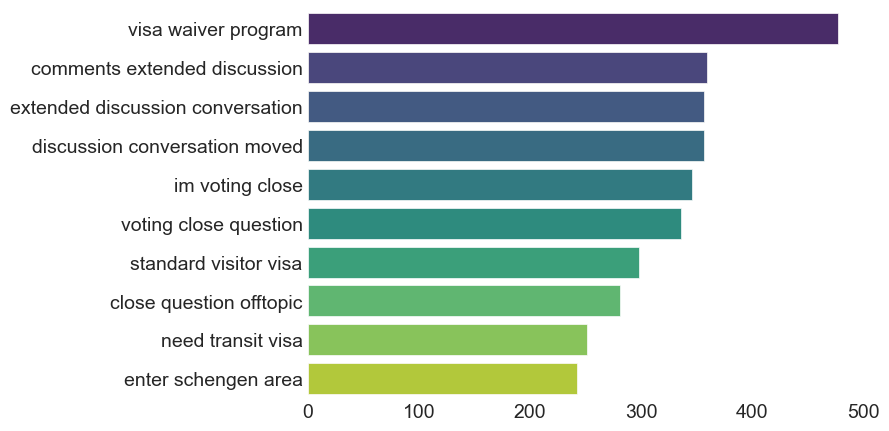

In [415]:
plot_barplot_for_mostcommom(mostCommon_3grams_precipitation_0, title="most common 3grams precipitation_0")

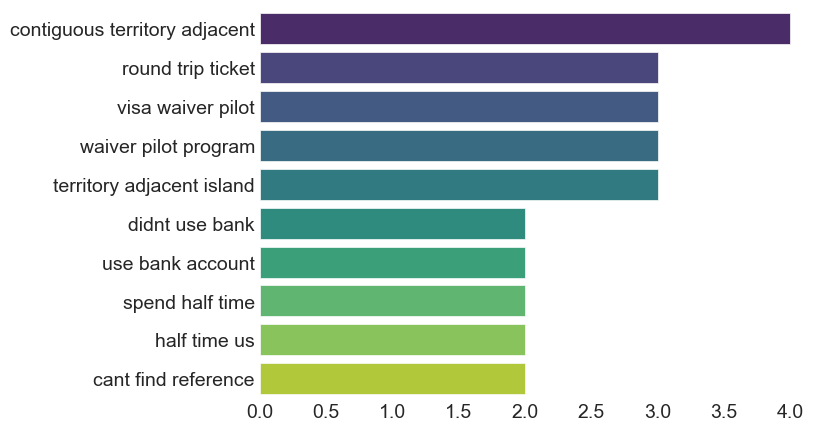

In [416]:
plot_barplot_for_mostcommom(mostCommon_3grams_precipitation_5, title="most common 3grams precipitation_5")

In [417]:
# plot_barplot_for_mostcommom(most_common_3grams_20, title="most common 3grams above 20")

In [631]:
# extract location names
# spacy is slow as always :_( ...35mins

import spacy
nlp = spacy.load('en_core_web_sm')

def extract_locations(tokens):
    locations = []
    
    text = " ".join(tokens)
    doc = nlp(text)    
    for entity in doc.ents:
       if entity.label_ == 'GPE':
          locations.append(entity.text)
    return locations
merged_weather_texts_preprocessed["locations"] = merged_weather_texts_preprocessed.Text.progress_apply(extract_locations)

100%|█████████████████████████████████| 127619/127619 [3:32:57<00:00,  9.99it/s]


In [622]:
# import nltk
# from nltk import word_tokenize, pos_tag, ne_chunk
# from nltk.tree import Tree

# # Make sure you have the necessary NLTK data
# nltk.download('punkt')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('averaged_perceptron_tagger')

# def extract_locations_nltk(tokens):
#     locations = []

#     tagged_tokens = pos_tag(tokens)
#     named_entities = ne_chunk(tagged_tokens)
    
#     for chunk in named_entities:
#         if isinstance(chunk, Tree):
#             if chunk.label() == 'GPE':  # GPE: Geopolitical Entity
#                 location = " ".join(c[0] for c in chunk)
#                 locations.append(location)
#     return locations

# Apply the function to extract locations
merged_weather_texts_preprocessed["locations"] = merged_weather_texts_preprocessed.Text.progress_apply(extract_locations)


[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/admin/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
100%|███████████████████████████████████| 127619/127619 [22:19<00:00, 95.26it/s]


In [638]:
merged_weather_texts_preprocessed["locations"] 

0                                                        []
1                                     [japan, japan, japan]
2         [israel, jerusalem, tel aviv jerusalem, jerusa...
3                                     [new york, singapore]
4                                               [frankfurt]
                                ...                        
127614                                           [portugal]
127615                                                   []
127616                                      [united states]
127617                                                   []
127618                                                   []
Name: locations, Length: 127619, dtype: object

In [633]:
def get_most_common_locs_n(df, n=10):
    corpus = []
    for i in trange(df.shape[0], colour='green'):
        corpus += df['locations'][i]
    mostCommon = Counter(corpus).most_common(n)
    return mostCommon

In [640]:
mostCommon_losc_0 = get_most_common_locs_n(cluster_below_0)
mostCommon_losc_0_26 = get_most_common_locs_n(cluster_0_26)
mostCommon_losc_26 = get_most_common_locs_n(cluster_above_26)

mostCommon_losc_hum_30 = get_most_common_locs_n(cluster_relative_humidity_2m_30)
mostCommon_losc_hum_90 = get_most_common_locs_n(cluster_relative_humidity_2m_90)

mostCommon_losc_precipitation_0 = get_most_common_locs_n(cluster_precipitation_0)
mostCommon_losc_precipitation_5 = get_most_common_locs_n(cluster_precipitation_5)

100%|██████████████████████████████████████| 114/114 [00:00<00:00, 65625.95it/s]


In [642]:
mostCommon_losc_0

[('canada', 390),
 ('london', 204),
 ('germany', 172),
 ('india', 166),
 ('united states', 137),
 ('france', 132),
 ('us', 121),
 ('uk', 115),
 ('new york', 103),
 ('toronto', 102)]

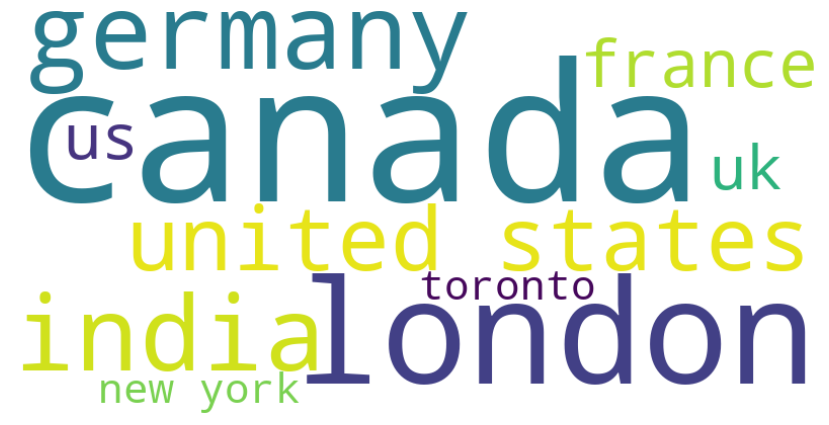

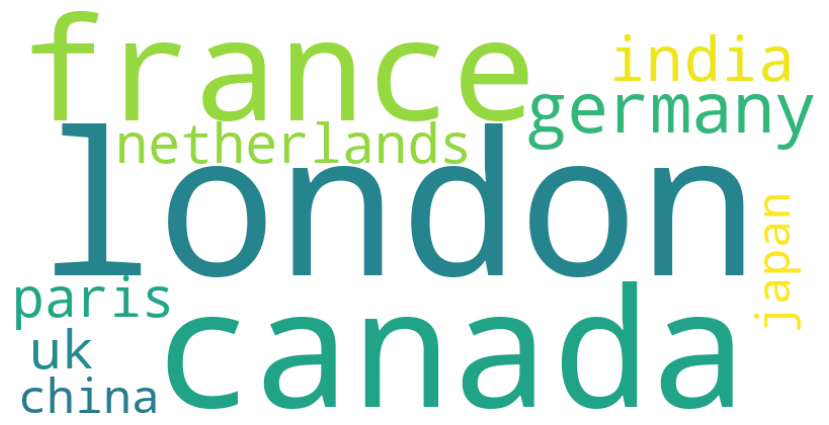

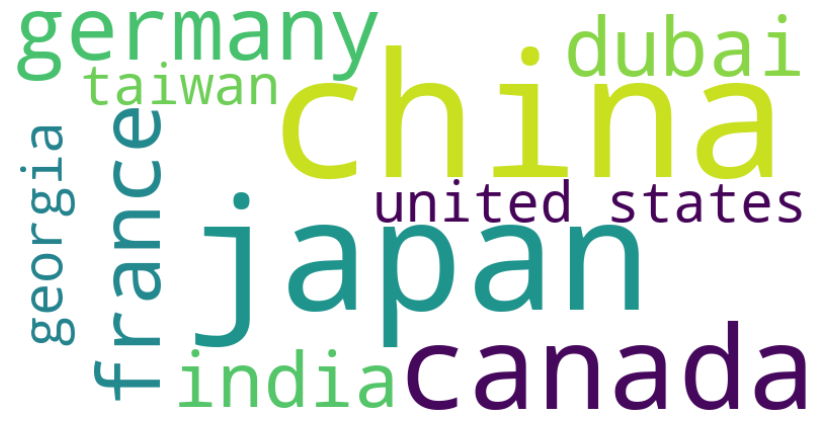

In [645]:
generate_word_cloud_from_most_common(mostCommon_losc_0)
generate_word_cloud_from_most_common(mostCommon_losc_0_26)
generate_word_cloud_from_most_common(mostCommon_losc_26)

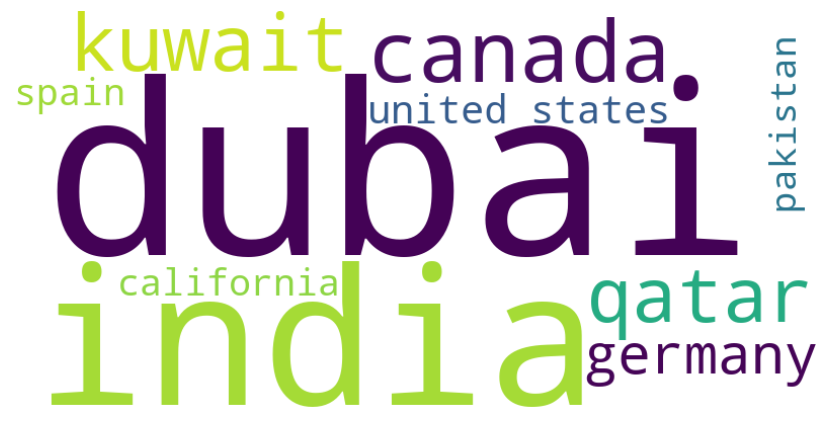

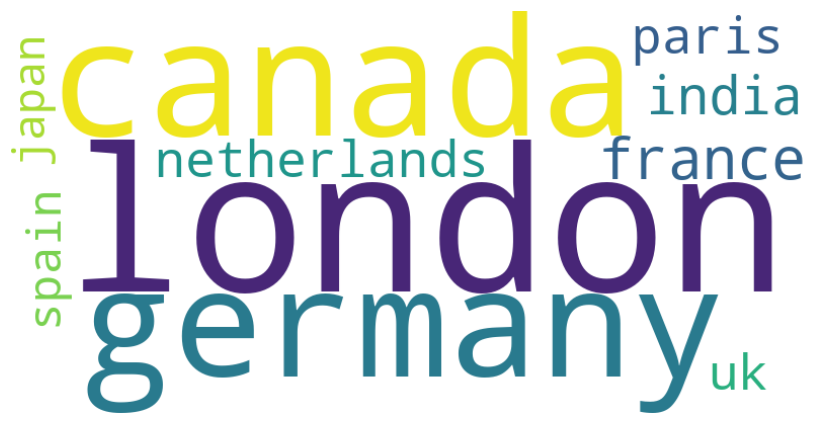

In [646]:

generate_word_cloud_from_most_common(mostCommon_losc_hum_30)
generate_word_cloud_from_most_common(mostCommon_losc_hum_90)


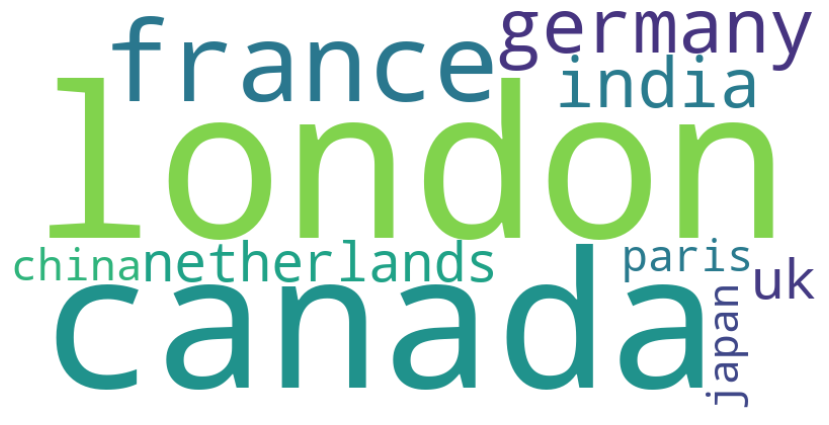

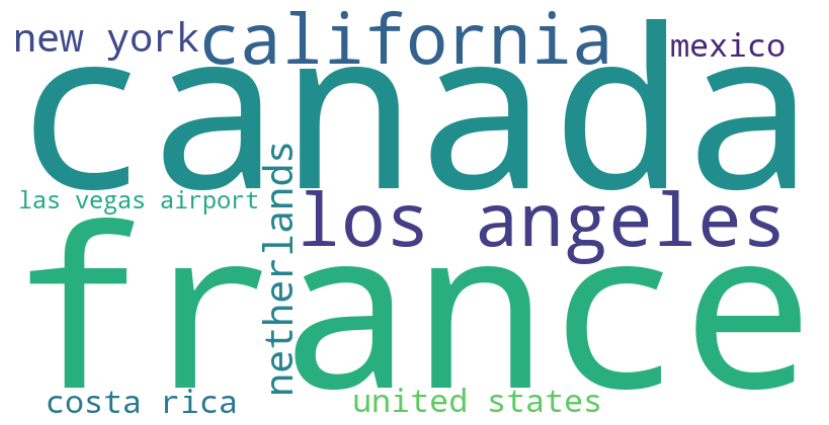

In [647]:

generate_word_cloud_from_most_common(mostCommon_losc_precipitation_0)
generate_word_cloud_from_most_common(mostCommon_losc_precipitation_5)

In [ ]:
# !pip install wordcloud

In [586]:
from wordcloud import WordCloud

def generate_word_cloud_from_most_common(most_common_df):
    word_count_dict = dict(most_common_df)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [587]:
merged_weather_texts_preprocessed.head(1)

,Text,Title,Tags,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,location,temperature_mean,OriginalText,Text_lemma,PreprocessedText
0,"[singapore, airlines, allbusiness, class, flig...",Does Singapore Airlines offer any reward seats...,<loyalty-programs><routes><ewr><singapore-airl...,2011-06-21 20:00:00,26.357,61.469131,28.947426,0.0,0.0,"New York, NY",27.652214,<p>Singapore Airlines has an all-business clas...,"[singapore, airlines, allbusiness, class, flig...",singapore airlines allbusiness class flight ew...


In [313]:
#merged_weather_texts_preprocessed.Text_lemma[1], merged_weather_texts_preprocessed.Text[1]

In [316]:
# merged_weather_texts_preprocessed.locations

In [732]:
# extract words like (hot/cold/freezing/warm/)

Temperature: Temperature, Degrees, Celsius, Fahrenheit, Warm, Cold, Hot, Chilly, Freezing, Boiling, Mild, Cool
Precipitation: Rainy, Rainfall, Showers, Drizzle, Downpour, Thunderstorm, Snowy, Snowfall, Blizzard, Sleet, Hail
Wind: Windy, Wind, speed, Gusts, Breezy, Gale, Cyclone, Tornado, Hurricane, Typhoon, Whirlwind
Clouds: Cloudy, Overcast, Partly, cloudy, Clear, skies, Cumulus, Cirrus, Stratus, Nimbus, Foggy, Misty
Atmospheric Pressure: High, pressure, Low, Barometric, pressure, Atmospheric, system, gradient
Humidity: Humid, Dry, Moist, Humidity, level, Relative, Dew, point, Muggy
Seasons: Spring, Summer, Autumn/Fall, Winter, Monsoon, Dry, season, Wet, Harvest
Conditions: Sunny, Clear, Fair, Fine, Pleasant, Stormy, Changeable, Variable, Unsettled, Extreme
Events: Heatwave, Cold, snap, Frontal, Severe, Natural, disaster, warning, forecast, Climate
Other: UV, index, Sunrise, Sunset, Moon, phase, Visibility, Air, quality, report, satellite, radar, station

In [606]:
def extract_weather_words(tokens):
    
    weather_words = [
    # Temperature
    "Warm", "Cold", "Hot", "Chilly", "Freezing", "Boiling", "Mild", "Cool",
    # Precipitation
    "Rainy", "Rainfall", "Showers", "Drizzle", "Downpour", "Thunderstorm", "Snowy", "Snowfall", "Blizzard", "Sleet", "Hail",
    # Wind
    "Windy", "Wind", "Gusts", "Breezy", "Gale", "Cyclone", "Tornado", "Hurricane", "Typhoon", "Whirlwind",
    # Clouds
    "Cloudy", "Overcast", "Partly", "cloudy", "skies", "Cumulus", "Cirrus", "Stratus", "Nimbus", "Foggy", "Misty",
    # Atmospheric Pressure
    "pressure", "Barometric", "Atmospheric", "gradient",
    # Humidity
    "Humid", "Dry", "Moist", "Humidity", "Relative", "Dew", "Muggy",
    # Seasons
    "Spring", "Summer", "Autumn", "Winter", "Monsoon", "Dry", "Wet", "Harvest",
    # Conditions
    "Sunny", "Fair", "Pleasant", "Stormy", "Changeable", "Variable", "Unsettled", "Extreme",
    # Events
    "Heatwave", "Cold", "snap", "Frontal", "Severe", "Natural", "disaster", "warning", "forecast", "Climate",
    # Other
    "UV", "index", "Sunrise", "Sunset", "Moon", "phase", "Visibility", "quality", "satellite", "radar"
]

    weather_words_lc = [word.lower() for word in weather_words]
    
    wwords = []
    for token in tokens:
        if token in weather_words_lc:
            wwords.append(token)
    return wwords
merged_weather_texts_preprocessed["weather_tokens"] = merged_weather_texts_preprocessed.Text_lemma.progress_apply(extract_weather_words)

Processing Rows: 100%|███████████████| 127619/127619 [00:07<00:00, 17658.57it/s]


In [639]:
# againg just grouping data as previously 
cluster_below_0 = merged_weather_texts_preprocessed[merged_weather_texts_preprocessed.temperature_mean <= 0] \
                    .reset_index().drop(columns = "index")
cluster_0_26 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.temperature_mean > 0) & (merged_weather_texts_preprocessed.temperature_mean < 26)] \
                    .reset_index().drop(columns = "index")
cluster_above_26 = merged_weather_texts_preprocessed[merged_weather_texts_preprocessed.temperature_mean >= 26] \
                    .reset_index().drop(columns = "index")

cluster_relative_humidity_2m_30 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.relative_humidity_2m <= 30)] \
                    .reset_index().drop(columns = "index")
cluster_relative_humidity_2m_90 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.relative_humidity_2m >= 90)] \
                    .reset_index().drop(columns = "index")

cluster_precipitation_0 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.precipitation == 0)] \
                    .reset_index().drop(columns = "index")
cluster_precipitation_5 = merged_weather_texts_preprocessed[(merged_weather_texts_preprocessed.precipitation >= 5)] \
                    .reset_index().drop(columns = "index")

In [608]:
# cluster_above_26["weather_tokens"]

In [619]:
cluster_above_26["weather_tokens"][cluster_above_26['weather_tokens'].apply(len) != 0]

19       [dry, dry, hot, dry, dry, dry, cold, dry, hot,...
27                              [atmospheric, atmospheric]
28                                               [harvest]
32                                              [pleasant]
59                                         [quality, fair]
                               ...                        
13486                                                [hot]
13530                                             [spring]
13554                                           [relative]
13679                                    [summer, natural]
13778                                             [severe]
Name: weather_tokens, Length: 527, dtype: object

In [610]:
cluster_above_26["OriginalText"][13789]

'Since while *inside Latvia* you were **not** in (or traveled through in transit) a country with a high infection rate, the conditions for peaple who ***arrived* from countries in which the 14-day cumulative number of COVID-19 cases has exceeded 16 individuals per 100,000** do not apply to you.'

In [611]:
cluster_above_26["OriginalText"][13745]

'Where does your British husband reside? If neither of you have ties to your country of residence but you *do have* ties to the UK IMHO you’re not likely to be given a visitor visa. In the eyes of the ECO, without a compelling reason to leave the UK the risk that you’d overstay would likely be considered high.'

In [612]:
def get_most_common_weatherw_n(df, n=10):
    corpus = []
    for i in trange(df.shape[0], colour='green'):
        corpus += df['weather_tokens'][i]
    mostCommon = Counter(corpus).most_common(n)
    return mostCommon

In [613]:
mostCommon_weatherw_0 = get_most_common_weatherw_n(cluster_below_0)
mostCommon_weatherw_0_26 = get_most_common_weatherw_n(cluster_0_26)
mostCommon_weatherw_26 = get_most_common_weatherw_n(cluster_above_26)

mostCommon_weatherw_hum_30 = get_most_common_weatherw_n(cluster_relative_humidity_2m_30)
mostCommon_weatherw_hum_90 = get_most_common_weatherw_n(cluster_relative_humidity_2m_90)

mostCommon_weatherw_precipitation_0 = get_most_common_weatherw_n(cluster_precipitation_0)
mostCommon_weatherw_precipitation_5 = get_most_common_weatherw_n(cluster_precipitation_5)

100%|██████████████████████████████████████| 114/114 [00:00<00:00, 62881.46it/s]


In [614]:
# mostCommon_weatherw_0, mostCommon_weatherw_26
cluster_above_26["weather_tokens"][cluster_above_26['weather_tokens'].apply(len) != 0]

19       [dry, dry, hot, dry, dry, dry, cold, dry, hot,...
27                              [atmospheric, atmospheric]
28                                               [harvest]
32                                              [pleasant]
59                                         [quality, fair]
                               ...                        
13486                                                [hot]
13530                                             [spring]
13554                                           [relative]
13679                                    [summer, natural]
13778                                             [severe]
Name: weather_tokens, Length: 527, dtype: object

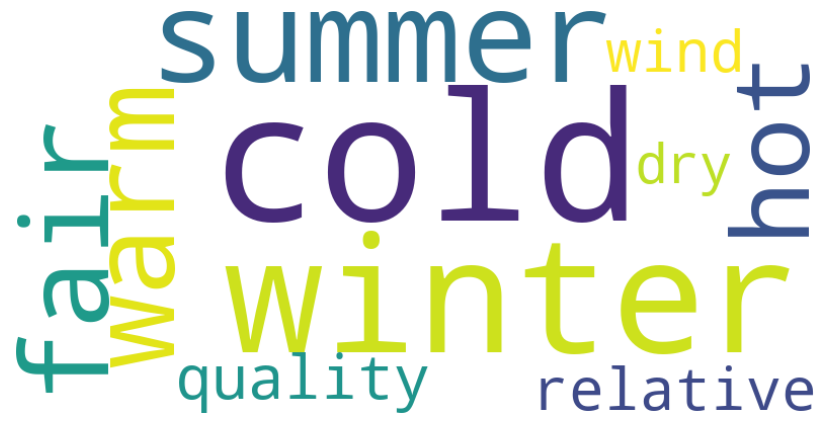

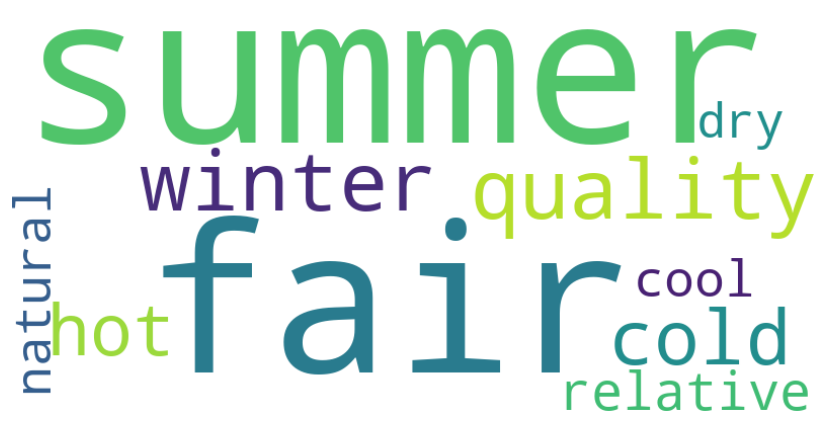

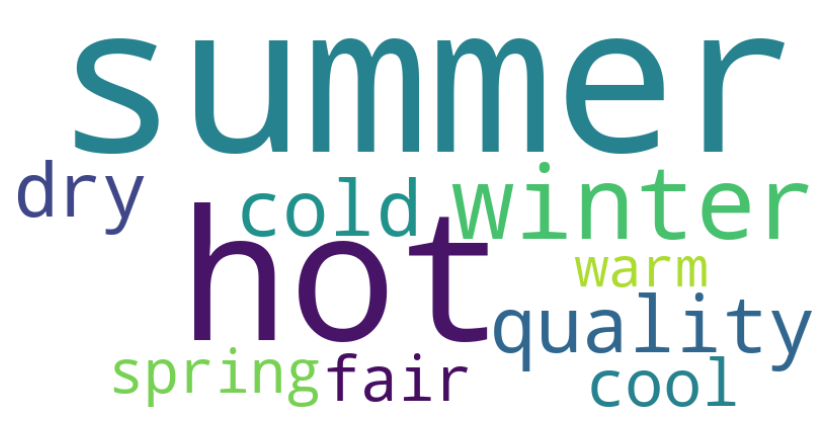

In [615]:
generate_word_cloud_from_most_common(mostCommon_weatherw_0)
generate_word_cloud_from_most_common(mostCommon_weatherw_0_26)
generate_word_cloud_from_most_common(mostCommon_weatherw_26)

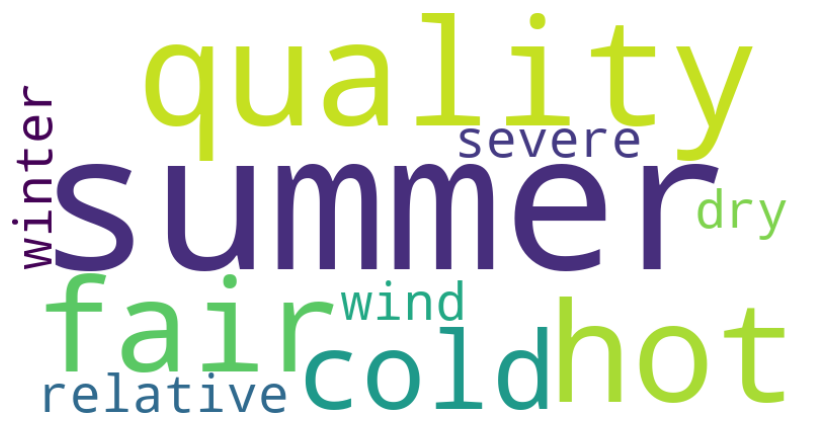

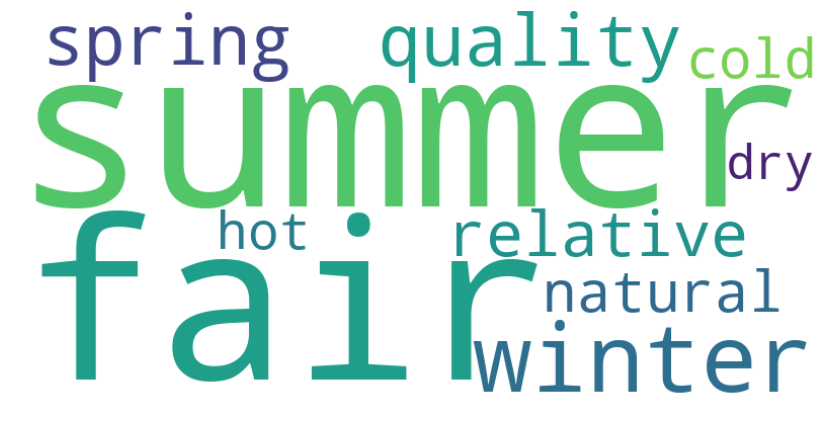

In [616]:
generate_word_cloud_from_most_common(mostCommon_weatherw_hum_30)
generate_word_cloud_from_most_common(mostCommon_weatherw_hum_90)

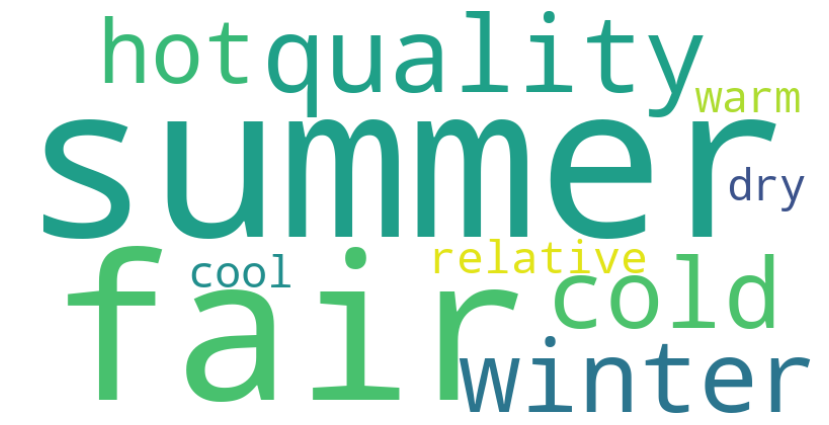

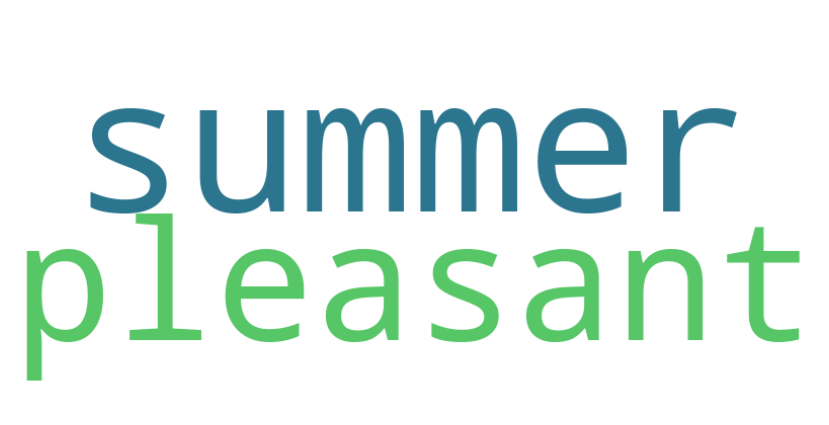

In [617]:
generate_word_cloud_from_most_common(mostCommon_weatherw_precipitation_0)
generate_word_cloud_from_most_common(mostCommon_weatherw_precipitation_5)